In [2]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from AnalyticCoolingCurves import *
from unpackConfigurations import unpackConfiguration
from unpackConfigurationsMK import unpackConfigurationMK
import ThermalFrontFormulation as TF
from matplotlib.collections import LineCollection
import os
import pickle as pkl
from LRBv2 import LRBv2
import matplotlib as mpl
import copy
from LengyelReinkeFormulation import *
import ThermalFrontFormulation as TF
import colorcet as cc
from scipy import interpolate
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, MultipleLocator, FormatStrFormatter, AutoMinorLocator

from DLScommonTools import *

%load_ext autoreload
%autoreload 2

set_matplotlib_defaults()



# IO

In [3]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # in development
    "upstreamGrid": False, #if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, #upstream density
    "nu0" : 1e20,
    "cz0" : 0.02,
    "kappa0" : 2500,
    "mi": 3*10**(-27),
    "echarge": 1.60*10**(-19), 
    "Tt": 0.5, # requested virtual target temp. Aim for low (sub 1eV) Tt
    "Lfunc": LfuncKallenbachAr, #impurity cooling function
    "alpha": 1000, #flux limiting alpha. Only matters if fluxlim is true
}


In [4]:
gridFile = r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc"

list_sides = ["iu", "ou"]
data = dict()
sepadd = 2
res = 500

for side in list_sides:
    data[side] = unpackConfigurationMK(
        File = gridFile, Type = side, sepadd = 2, resolution = res, convention = "target_to_midplane")

# Morph

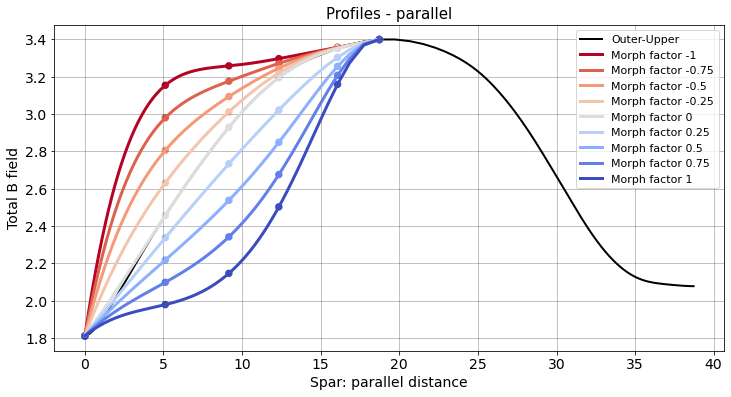

In [5]:
d = data["ou"]
controls = [0, d["Xpoint"]]
controls = np.linspace(0, d["Xpoint"], 4).astype(int)
controls = np.insert(controls, -1, int(controls[-1]-6))
controls = [0, 100, 150, 170, 180, d["Xpoint"]]

leg_x = d["S"][:d["Xpoint"]+1] # Plus 1 because otherwise it doesnt include Xpoint itself
x_base = d["S"][(controls)]
y_base = d["Btot"][(controls)]
Bx = d["Btot"][d["Xpoint"]]
Bt = d["Btot"][0]
Sx = d["S"][d["Xpoint"]]

y_fit_base = interpolate.InterpolatedUnivariateSpline(x_base,y_base)(leg_x)            

# when morph = 1, points line up with Xpoint. when morph = 0, line up with target
def adjust(array, index, morph, mod):
    if morph != 0:  
        if morph > 0:
            distance = Bt - array[index]
        if morph < 0:
            distance = Bx - array[index]  
        array[index] += distance*abs(morph * mod)
    return array
    
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(d["S"], d["Btot"],  linewidth = 2, linestyle = "solid", label = "Outer-Upper", zorder = 0, markersize = 0, color = "black", marker = "o")

list_morph = [-1, -0.75, -0.5,-0.25, 0, 0.25, 0.5, 0.75, 1]
colors = make_colors(len(list_morph), plt.get_cmap("coolwarm"))[::-1]
# colors = [plt.get_cmap("Dark2")(x) for x in range(len(list_morph))]

morphdata = dict()

for i, morph in enumerate(list_morph):#[-1, -0.5, 0, 0.3, 0.5]:
    
    y_morph = y_base.copy()
    y_morph = adjust(y_morph, 1, morph, mod = 0.74)
    y_morph = adjust(y_morph, 2, morph, mod = 0.7)
    y_morph = adjust(y_morph, 3, morph, mod = 0.5)
    y_morph = adjust(y_morph, 4, morph, mod = 0.125)
    y_fit_morph = interpolate.InterpolatedUnivariateSpline(x_base,y_morph, k = 4)(leg_x) 
    
    morphdata[f"ou_m{i}"] = copy.deepcopy(data["ou"])
    morphdata[f"ou_m{i}"]["Btot"] = np.concatenate([y_fit_morph, d["Btot"][d["Xpoint"]+1:]]) # Plus 1 because y_fit_morph and leg_x has -1
    morphdata[f"ou_m{i}"]["morph"] = morph

    ax.scatter(x_base, y_morph, color = colors[i], s = 20, facecolor="None", linewidth = 3, zorder = 1)
    ax.plot(leg_x, y_fit_morph, linewidth = 3, linestyle = "solid", zorder = 5, label = f"Morph factor {morph}", marker = "o", alpha = 1, markersize = 0, color = colors[i])

ylims = ax.axes.get_ylim()

ax.set_title("Profiles - parallel", fontsize = 15)
ax.legend(fontsize = 11)
ax.set_xlabel("Spar: parallel distance"); 
ax.set_ylabel("Total B field")
ax.grid(color = "black", alpha = 0.3)


## Check

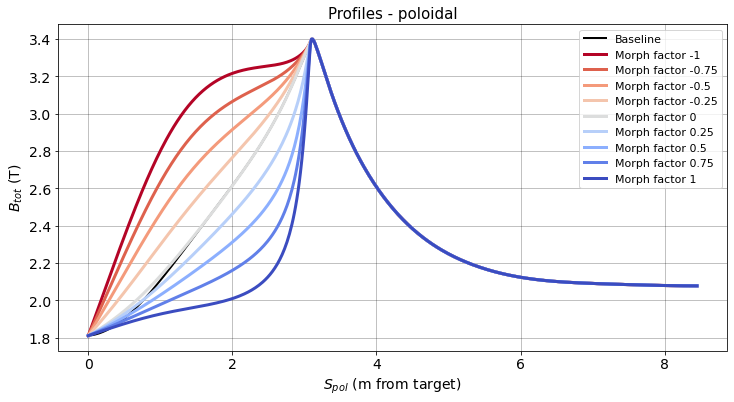

In [6]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(d["Spol"], d["Btot"],  linewidth = 2, linestyle = "solid", label = "Baseline", zorder = 0, markersize = 0, color = "black", marker = "o")


colors = make_colors(len(list_morph), plt.get_cmap("coolwarm"))[::-1]
# colors = [plt.get_cmap("Dark2")(x) for x in range(len(list_morph))]

for i, morph in enumerate(list_morph):#[-1, -0.5, 0, 0.3, 0.5]:

    # ax.scatter(x_base, y_morph, color = colors[i], s = 20, facecolor="None", linewidth = 3, zorder = 1)
    ax.plot(morphdata[f"ou_m{i}"]["Spol"], morphdata[f"ou_m{i}"]["Btot"], linewidth = 3, linestyle = "solid", zorder = 5, label = f"Morph factor {morph}", marker = "o", alpha = 1, markersize = 0, color = colors[i])

ylims = ax.axes.get_ylim()

ax.set_title("Profiles - poloidal", fontsize = 15)
ax.legend(fontsize = 11)
ax.set_xlabel("$S_{pol}$ (m from target)"); 
ax.set_ylabel("$B_{tot}$ (T)")
ax.grid(color = "black", alpha = 0.3)

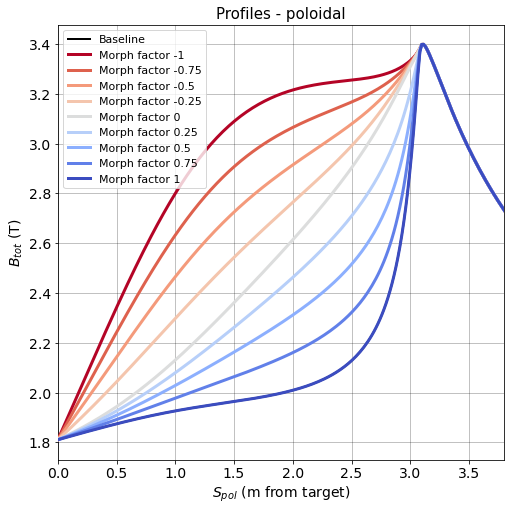

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(d["Spol"], d["Btot"],  linewidth = 2, linestyle = "solid", label = "Baseline", zorder = 0, markersize = 0, color = "black", marker = "o")


colors = make_colors(len(list_morph), plt.get_cmap("coolwarm"))[::-1]
# colors = [plt.get_cmap("Dark2")(x) for x in range(len(list_morph))]

for i, morph in enumerate(list_morph):#[-1, -0.5, 0, 0.3, 0.5]:

    # ax.scatter(x_base, y_morph, color = colors[i], s = 20, facecolor="None", linewidth = 3, zorder = 1)
    ax.plot(morphdata[f"ou_m{i}"]["Spol"], morphdata[f"ou_m{i}"]["Btot"], linewidth = 3, linestyle = "solid", zorder = 5, label = f"Morph factor {morph}", marker = "o", alpha = 1, markersize = 0, color = colors[i])

ylims = ax.axes.get_ylim()
ax.set_xlim(0,3.8)
ax.set_title("Profiles - poloidal", fontsize = 15)
ax.legend(fontsize = 11)
ax.set_xlabel("$S_{pol}$ (m from target)"); 
ax.set_ylabel("$B_{tot}$ (T)")
ax.grid(color = "black", alpha = 0.3)

# Run

In [34]:
morph_study = dict()

for side in morphdata.keys():
    print("Solving side", side)
    out = []
    results = dict()
    
    for param in ["window", "threshold", "window_ratio"]:
        results[param] = []


    d = morphdata[side].copy()
    i = 0
    
    constants = constants_default.copy()
    radios = radios_default.copy()
    indexRange = np.linspace(0, d["Xpoint"]-1, 15).astype(int)
    radios["upstreamGrid"] = True
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

    out.append(LRBv2(constants,radios,d["S"],indexRange, 
                                        Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 1, verbosity = 0,
                                        control_variable = "density"))

    out[i]["SpolPlot"] = [d["Spol"][x] for x in indexRange]
    results["window"].append(out[i]["cvar"][-1] - out[i]["cvar"][0])
    results["window_ratio"].append(out[i]["cvar"][-1] / out[i]["cvar"][0])
    results["threshold"].append(out[i]["cvar"][0])
    results["indexRange"] = indexRange
    results["constants"] = constants
    results["radios"] = radios
    results["out"] = out
    
    # Take out any thresholds for a window ratio < 1
    for i, x in enumerate(results["threshold"]):
        if results["window_ratio"][i] < 1:
            results["threshold"][i] = np.nan
    try:
        results["rel_threshold"] = results["threshold"] / max([x for x in results["threshold"] if ~np.isnan(x)])
    except:
        pass
    morph_study[side] = results.copy()

Solving side ou_m0
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 18.2 seconds
Solving side ou_m1
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 16.7 seconds
Solving side ou_m2
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 16.8 seconds
Solving side ou_m3
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 17.7 seconds
Solving side ou_m4
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 15.1 seconds
Solving side ou_m5
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 16.3 seconds
Solving side ou_m6
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 18.7 seconds
Solving side ou_m7
Solving...0...13...26...39...52...65

## Profiles

Text(0.5, 1.0, 'Outer divertor morph front position scan')

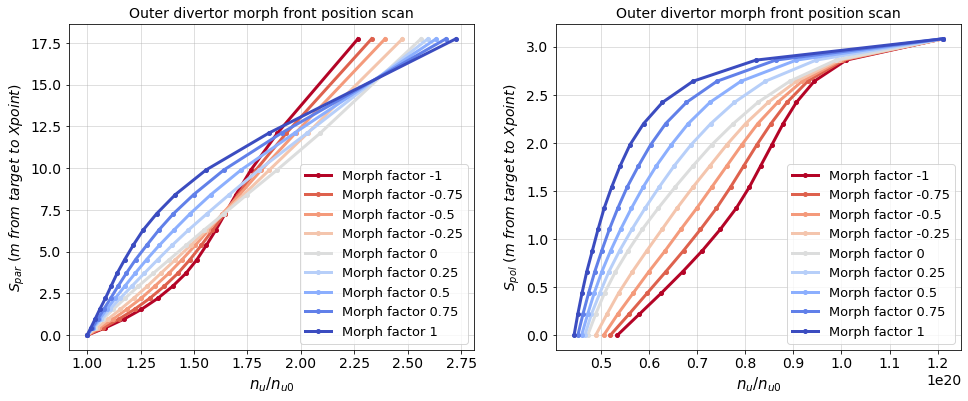

In [676]:
fig, axes = plt.subplots(1,2, figsize = (16,6))

ax = axes[0]
for i, side in enumerate(list_morph):
    o = morph_study[f"ou_m{i}"]["out"][0]
    ax.plot(o["crel"], o["Splot"], label = "Morph factor {}".format(side), linewidth = 3, marker = "o", markersize = 4, color = colors[i])
    
ax.set_xlabel("$n_{u}$/$n_{u0}$", fontsize = 15)
ax.set_ylabel("$S_{par}\ (m\ from\ target\ to\ Xpoint)$")
ax.grid(alpha = 0.5)
ax.legend(fontsize = 13)
ax.set_title("Outer divertor morph front position scan")

ax = axes[1]
for i, side in enumerate(list_morph):
    o = morph_study[f"ou_m{i}"]["out"][0]
    ax.plot(o["cvar"], o["SpolPlot"], label = "Morph factor {}".format(side), linewidth = 3, marker = "o", markersize = 4, color = colors[i])
    
ax.set_xlabel("$n_{u}$/$n_{u0}$", fontsize = 15)
ax.set_ylabel("$S_{pol}\ (m\ from\ target\ to\ Xpoint)$")
ax.grid(alpha = 0.5)
ax.legend(fontsize = 13)
ax.set_title("Outer divertor morph front position scan")


## Relative change in window

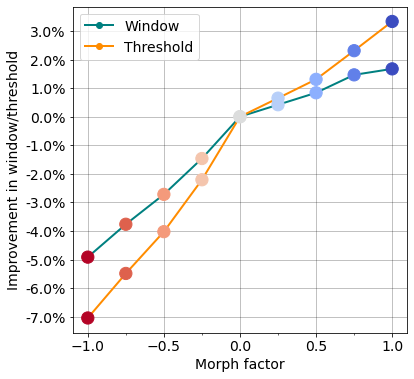

In [63]:
windows = [morph_study[x]["window"][0] for x in morph_study.keys()]
thresholds = [morph_study[x]["threshold"][0] for x in morph_study.keys()]
morphs = [morphdata[x]["morph"] for x in morphdata.keys()]
window_base = morph_study["ou_m{}".format(int(len(list_morph) / 2))]["window"] # Find window of middle value, assuming we always have an odd number of morphs
threshold_base = morph_study["ou_m{}".format(int(len(list_morph) / 2))]["threshold"] 
rel_windows = (np.array(windows) - window_base) / window_base
rel_thresholds = 1/((np.array(thresholds))/threshold_base) -1

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(morphs, rel_windows, marker = "o", color = "teal", linewidth = 2, label = "Window")
ax.scatter(morphs, rel_windows, marker = "o", color = colors, zorder = 100, s = 150)
ax.plot(morphs, rel_thresholds, marker = "o", color = "darkorange", linewidth = 2,  label = "Threshold")
ax.scatter(morphs, rel_thresholds, marker = "o", color = colors, zorder = 100, s = 150)
ax.grid(color = "black", alpha = 0.3)
ax.set_xlabel("Morph factor")
ax.set_ylabel("Improvement in window/threshold")
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.1%}"))
ax.yaxis.set_major_locator(MultipleLocator(0.01))
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.legend()

In [54]:
colors

[(0.705673158, 0.01555616, 0.150232812, 1.0),
 (0.8696552305058823, 0.37927381945098043, 0.30094110221960785, 1.0),
 (0.9582793979254902, 0.604335096882353, 0.48329710138823534, 1.0),
 (0.9581760317411765, 0.7712340904, 0.6803010368117647, 1.0),
 (0.863391831290196, 0.8650837958196078, 0.8676338842627451, 1.0),
 (0.7189852929803922, 0.811992893745098, 0.9776561613921568, 1.0),
 (0.5488761722823529, 0.6851035851764705, 0.9943791404235295, 1.0),
 (0.3785982492705882, 0.5038562171921569, 0.9136916108470589, 1.0),
 (0.2298057, 0.298717966, 0.753683153, 1.0)]

## Connection to average B and average gradient

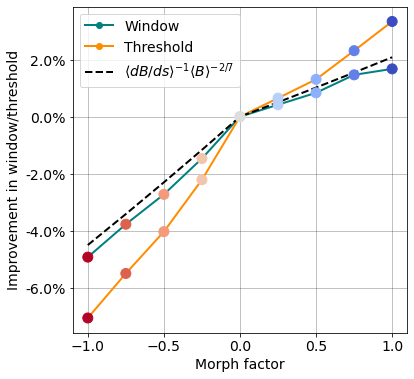

In [78]:
Btot_avg = [np.mean(morphdata[x]["Btot"]) for x in morphdata.keys()]
Btot_grad_avg = [np.mean(np.gradient(morphdata[x]["Btot"])) for x in morphdata.keys()]

Btot_avg_rel = (Btot_avg - Btot_avg[base_index]) / Btot_avg[base_index]
Btot_grad_avg_rel = (Btot_grad_avg - Btot_grad_avg[base_index]) / Btot_grad_avg[base_index]


windows = [morph_study[x]["window"][0] for x in morph_study.keys()]
thresholds = [morph_study[x]["threshold"][0] for x in morph_study.keys()]
morphs = [morphdata[x]["morph"] for x in morphdata.keys()]
window_base = morph_study["ou_m{}".format(int(len(list_morph) / 2))]["window"] # Find window of middle value, assuming we always have an odd number of morphs
threshold_base = morph_study["ou_m{}".format(int(len(list_morph) / 2))]["threshold"] 
rel_windows = (np.array(windows) - window_base) / window_base
rel_thresholds = 1/((np.array(thresholds))/threshold_base) -1

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(morphs, rel_windows, marker = "o", color = "teal", linewidth = 2, label = "Window")
ax.scatter(morphs, rel_windows, marker = "o", color = colors, zorder = 100, s = 100)
ax.plot(morphs, rel_thresholds, marker = "o", color = "darkorange", linewidth = 2,  label = "Threshold")
ax.scatter(morphs, rel_thresholds, marker = "o", color = colors, zorder = 100, s = 100)

# ax.plot(morphs, Btot_avg_rel, marker = "o", linewidth = 2, label = "Average Btot")
ax.plot(morphs, ((Btot_grad_avg_rel+1)**(-1)*(Btot_avg_rel+1)**(-2/7))-1, color = "black",  linewidth = 2,linestyle = "dashed", label = r"${\langle}dB/{ds}{\rangle}^{-1}{\langle}B{\rangle}^{-2/7}$")

ax.grid(color = "black", alpha = 0.3)
ax.set_xlabel("Morph factor")
ax.set_ylabel("Improvement in window/threshold")
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.1%}"))
# ax.yaxis.set_major_locator(MultipleLocator(0.01))
# ax.xaxis.set_major_locator(MultipleLocator(0.5))
# ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.legend()

Text(0.5, 1.0, 'Impact on density detachment window')

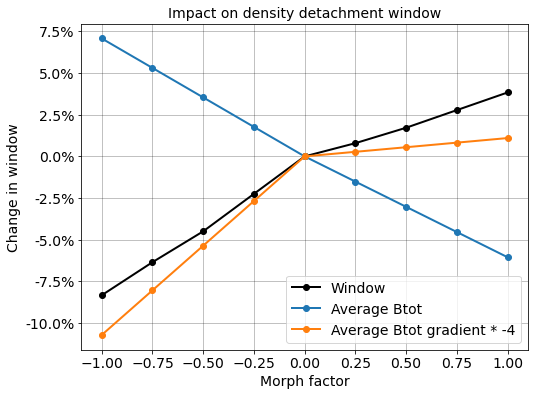

In [9]:
Btot_avg = [np.mean(morphdata[x]["Btot"]) for x in morphdata.keys()]
Btot_grad_avg = [np.mean(np.gradient(morphdata[x]["Btot"])) for x in morphdata.keys()]
windows = [morph_study[x]["window"][0] for x in morph_study.keys()]
morphs = [morphdata[x]["morph"] for x in morphdata.keys()]

base_index = int(len(list_morph) / 2)
window_base = morph_study["ou_m{}".format(base_index)]["window"] # Find window of middle value, assuming we always have an odd number of morphs
windows = (np.array(windows) - window_base) / window_base

Btot_avg_rel = (Btot_avg - Btot_avg[base_index]) / Btot_avg[base_index]
Btot_grad_avg_rel = (Btot_grad_avg - Btot_grad_avg[base_index]) / Btot_grad_avg[base_index] *-4

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(morphs, windows, marker = "o", color = "black", linewidth = 2, label = "Window")
ax.plot(morphs, Btot_avg_rel, marker = "o", linewidth = 2, label = "Average Btot")
ax.plot(morphs, Btot_grad_avg_rel, marker = "o", linewidth = 2, label = "Average Btot gradient * -4")

ax.legend()
ax.grid(color = "black", alpha = 0.3)
ax.set_xlabel("Morph factor")
ax.set_ylabel("Change in window")
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.1%}"))
ax.set_title("Impact on density detachment window")

Text(0.5, 1.0, 'Impact on density detachment window')

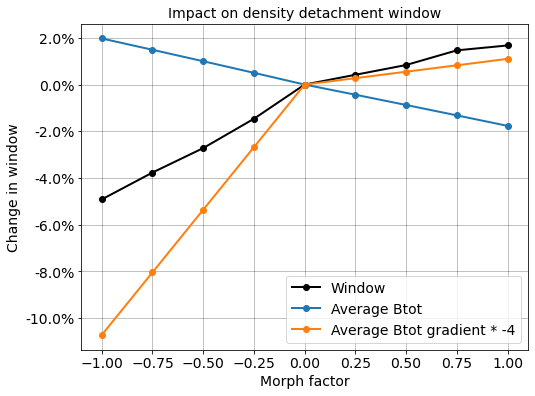

In [44]:
Btot_avg = [np.mean(morphdata[x]["Btot"]) for x in morphdata.keys()]
Btot_grad_avg = [np.mean(np.gradient(morphdata[x]["Btot"])) for x in morphdata.keys()]
windows = [morph_study[x]["window"][0] for x in morph_study.keys()]
morphs = [morphdata[x]["morph"] for x in morphdata.keys()]

base_index = int(len(list_morph) / 2)
window_base = morph_study["ou_m{}".format(base_index)]["window"] # Find window of middle value, assuming we always have an odd number of morphs
windows = (np.array(windows) - window_base) / window_base

Btot_avg_rel = (Btot_avg - Btot_avg[base_index]) / Btot_avg[base_index]
Btot_grad_avg_rel = (Btot_grad_avg - Btot_grad_avg[base_index]) / Btot_grad_avg[base_index] *-4

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(morphs, windows, marker = "o", color = "black", linewidth = 2, label = "Window")
ax.plot(morphs, (1+Btot_avg_rel)**(2/7)-1, marker = "o", linewidth = 2, label = "Average Btot")
ax.plot(morphs, Btot_grad_avg_rel, marker = "o", linewidth = 2, label = "Average Btot gradient * -4")

ax.legend()
ax.grid(color = "black", alpha = 0.3)
ax.set_xlabel("Morph factor")
ax.set_ylabel("Change in window")
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.1%}"))
ax.set_title("Impact on density detachment window")

# Check R coordinates of morphs

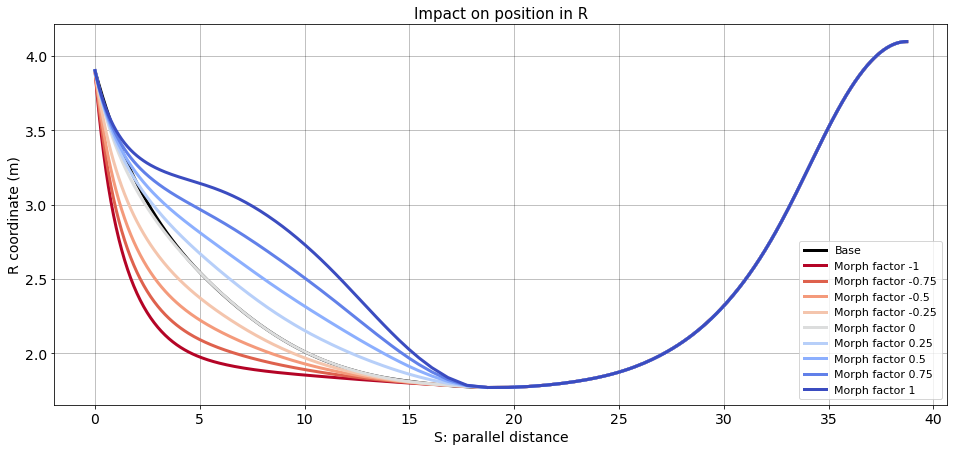

In [388]:
# for i, morph in enumerate(list_morph):
    
    

fig, ax = plt.subplots(figsize=(16,7))
ax.plot(data["ou"]["S"], data["ou"]["R"], linewidth = 3, linestyle = "solid", zorder = 5, label = f"Base", marker = "o", alpha = 1, markersize = 0, color = "black")

for i, morph in enumerate(list_morph):
    d = copy.deepcopy(morphdata[f"ou_m{i}"])
    d["R"] = data["ou"]["R"] *  data["ou"]["Btot"] / d["Btot"]
    
    ax.plot(d["S"], d["R"], linewidth = 3, linestyle = "solid", zorder = 5, label = f"Morph factor {morph}", marker = "o", alpha = 1, markersize = 0, color = colors[i])

    
ylims = ax.axes.get_ylim()

ax.set_title("Impact on position in R", fontsize = 15)
ax.legend(fontsize = 11)
ax.set_xlabel("S: parallel distance"); 
ax.set_ylabel("R coordinate (m)")
ax.grid(color = "black", alpha = 0.3)

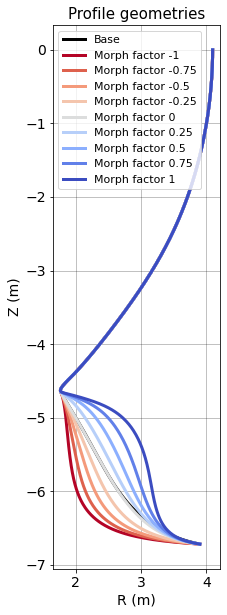

In [26]:
# for i, morph in enumerate(list_morph):
fig, ax = plt.subplots(figsize=(3,10))
ax.plot(data["ou"]["R"], -data["ou"]["Z"], linewidth = 3, linestyle = "solid", zorder = 5, label = f"Base", marker = "o", alpha = 1, markersize = 0, color = "black")

for i, morph in enumerate(list_morph):
    d = copy.deepcopy(morphdata[f"ou_m{i}"])
    d["R"] = data["ou"]["R"] *  data["ou"]["Btot"] / d["Btot"]
    
    ax.plot(d["R"], -d["Z"], linewidth = 3, linestyle = "solid", zorder = 5, label = f"Morph factor {morph}", marker = "o", alpha = 1, markersize = 0, color = colors[i])

    
ylims = ax.axes.get_ylim()

ax.set_title("Profile geometries", fontsize = 15)
ax.legend(fontsize = 11)
ax.set_xlabel("R (m)")
ax.set_ylabel("Z (m)")
ax.grid(color = "black", alpha = 0.3)

# Look at radiation profiles

In [51]:
morph_study.keys()

dict_keys(['ou_m0', 'ou_m1', 'ou_m2', 'ou_m3', 'ou_m4', 'ou_m5', 'ou_m6', 'ou_m7', 'ou_m8'])

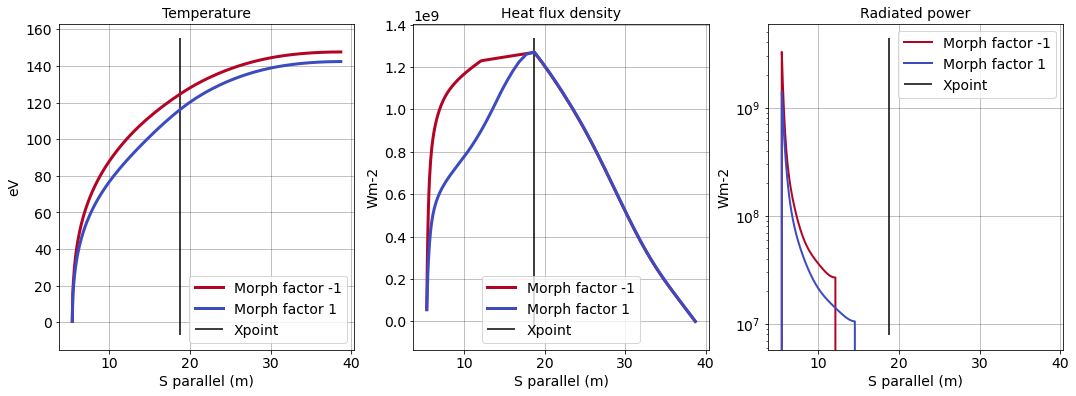

In [51]:
fig, axes = plt.subplots(1,3, figsize=(18,6))
Front = -7
store_colors = dict(zip(morphdata.keys(),make_colors(len(list_morph), plt.get_cmap("coolwarm"))[::-1]))

for case in ["ou_m0", "ou_m8"]:

    o = morph_study[case]["out"][0]
    morph = morphdata[case]["morph"]
    
    ax = axes[0]
    ax.plot(o["Sprofiles"][Front], o["Tprofiles"][Front], label = f"Morph factor {morph}", color = store_colors[case], linewidth = 3)
    ax.set_title("Temperature")
    ax.set_ylabel("eV")

    ax = axes[1]
    ax.plot(o["Sprofiles"][Front], o["Qprofiles"][Front], label = f"Morph factor {morph}", color = store_colors[case], linewidth = 3)
    ax.set_title("Heat flux density")
    ax.set_ylabel("Wm-2")
    
    ax = axes[2]
    ax.plot(o["Sprofiles"][Front], o["Rprofiles"][Front], label = f"Morph factor {morph}", color = store_colors[case], linewidth = 2)
    ax.set_title("Radiated power")
    ax.set_ylabel("Wm-2")
    ax.set_yscale("log")

for ax in axes:
    ylims = ax.get_ylim()
    ax.vlines(morphdata[case]["S"][morphdata[case]["Xpoint"]], ylims[0], ylims[1], color = "black", label = "Xpoint")
    ax.grid(color="black", alpha = 0.3)
    ax.set_xlabel("S parallel (m)")
    
    ax.legend()

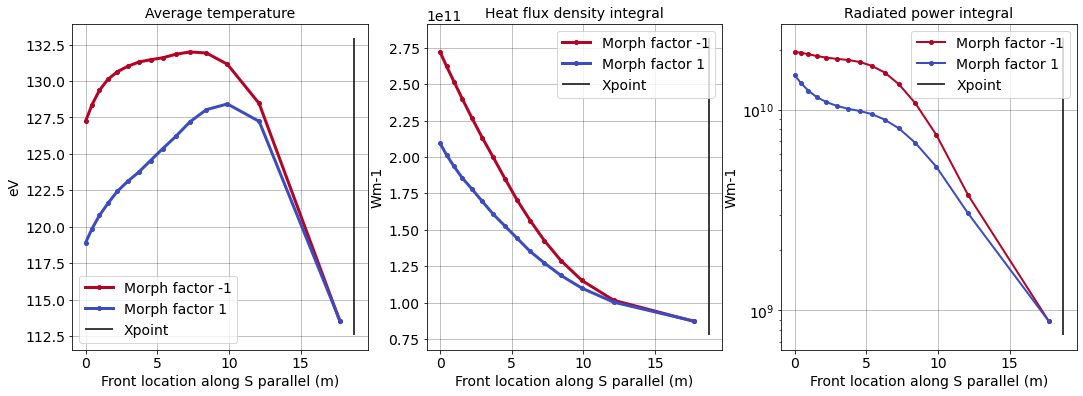

In [47]:
fig, axes = plt.subplots(1,3, figsize=(18,6))

store_colors = dict(zip(morphdata.keys(),make_colors(len(list_morph), plt.get_cmap("coolwarm"))[::-1]))

totals = dict()

for case in ["ou_m0", "ou_m8"]:
    o = morph_study[case]["out"][0]
    morph = morphdata[case]["morph"]
    
    totals[case] = dict()
    totals[case]["q_int"] = []; totals[case]["R_int"] = []; totals[case]["T_avg"] = []
    
    for Front in range(len(o["Sprofiles"])):
        totals[case]["q_int"].append(trapz(o["Qprofiles"][Front]))
        totals[case]["R_int"].append(trapz(o["Rprofiles"][Front]))
        totals[case]["T_avg"].append(np.mean(o["Tprofiles"][Front]))
        
    ax = axes[0]
    ax.plot(o["Splot"], totals[case]["T_avg"], label = f"Morph factor {morph}", marker = "o", markersize = 4, color = store_colors[case], linewidth = 3)
    ax.set_title("Average temperature")
    ax.set_ylabel("eV")

    ax = axes[1]
    ax.plot(o["Splot"], totals[case]["q_int"], label = f"Morph factor {morph}", marker = "o", markersize = 4, color = store_colors[case], linewidth = 3)
    ax.set_title("Heat flux density integral")
    ax.set_ylabel("Wm-1")
    
    ax = axes[2]
    ax.plot(o["Splot"], totals[case]["R_int"], label = f"Morph factor {morph}", marker = "o", markersize = 4, color = store_colors[case], linewidth = 2)
    ax.set_title("Radiated power integral")
    ax.set_ylabel("Wm-1")
    ax.set_yscale("log")
        
    
for ax in axes:
    ylims = ax.get_ylim()
    ax.vlines(morphdata[case]["S"][morphdata[case]["Xpoint"]], ylims[0], ylims[1], color = "black", label = "Xpoint")
    ax.grid(color="black", alpha = 0.3)
    ax.set_xlabel("Front location along S parallel (m)")
    
    ax.legend()

# Try nitrogen

In [34]:
morph_study_N = dict()

for side in morphdata.keys():
    print("Solving side", side)
    out = []
    results = dict()
    
    for param in ["window", "threshold", "window_ratio"]:
        results[param] = []


    d = morphdata[side].copy()
    i = 0
    
    constants = constants_default.copy()
    radios = radios_default.copy()
    indexRange = np.linspace(0, d["Xpoint"]-1, 15).astype(int)
    radios["upstreamGrid"] = True
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    constants["Lfunc"] = LfuncN
    constants["qpllu0"] = 2e9
    out.append(LRBv2(constants,radios,d["S"],indexRange, 
                                        Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 1, verbosity = 0,
                                        control_variable = "density"))

    out[i]["SpolPlot"] = [d["Spol"][x] for x in indexRange]
    
    results["window"].append(out[i]["cvar"][-1] - out[i]["cvar"][0])
    results["window_ratio"].append(out[i]["cvar"][-1] / out[i]["cvar"][0])
    results["threshold"].append(out[i]["cvar"][0])
    results["indexRange"] = indexRange
    results["constants"] = constants
    results["radios"] = radios
    results["out"] = out
    
    # Take out any thresholds for a window ratio < 1
    for i, x in enumerate(results["threshold"]):
        if results["window_ratio"][i] < 1:
            results["threshold"][i] = np.nan
    try:
        results["rel_threshold"] = results["threshold"] / max([x for x in results["threshold"] if ~np.isnan(x)])
    except:
        pass
    morph_study_N[side] = results.copy()

Solving side ou_m0
Solving...
---SOLVING FOR INDEX 0

cvar: 1.000E+20, error1: -2.214E-01
cvar: 2.000E+20, error1: 3.564E-01
Last error: -2.214E-01, New error: 3.564E-01
Bounds centering enabled, set to 1 iterations
-->Before centering: 1.000E+20-2.000E+20
-->After centering: 1.000E+20-2.000E+20
>Bounds: 1.000E+20-1.500E+20, cvar: 1.500E+20, error1: 6.670E-02
>Bounds: 1.250E+20-1.500E+20, cvar: 1.250E+20, error1: -7.764E-02
>Bounds: 1.375E+20-1.500E+20, cvar: 1.375E+20, error1: -5.528E-03
>Bounds: 1.375E+20-1.438E+20, cvar: 1.438E+20, error1: 3.057E-02
>Bounds: 1.375E+20-1.406E+20, cvar: 1.406E+20, error1: 1.252E-02
>Bounds: 1.375E+20-1.391E+20, cvar: 1.391E+20, error1: 3.495E-03
>Bounds: 1.383E+20-1.391E+20, cvar: 1.383E+20, error1: -1.017E-03
>Bounds: 1.383E+20-1.387E+20, cvar: 1.387E+20, error1: 1.239E-03
>Bounds: 1.383E+20-1.385E+20, cvar: 1.385E+20, error1: 1.109E-04
-----------error0: 0.000E+00, Tu: 190.99, Tucalc: 190.99
0...
---SOLVING FOR INDEX 13

cvar: 1.000E+20, error1: -2.

KeyboardInterrupt: 

## Profiles

Text(0.5, 1.0, 'Outer divertor morph front position scan')

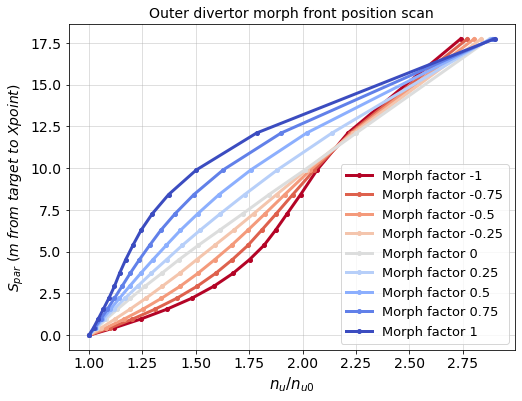

In [31]:
fig, ax = plt.subplots(figsize = (8,6))

# o = morph_study["ou"]["out"][0]
# ax.plot(o["crel"], o["Splot"], label = "Baseline", linewidth = 3, marker = "o", markersize = 4, color = "black")

for i, side in enumerate(list_morph):
    o = morph_study[f"ou_m{i}"]["out"][0]
    ax.plot(o["crel"], o["Splot"], label = "Morph factor {}".format(side), linewidth = 3, marker = "o", markersize = 4, color = colors[i])
    
ax.set_xlabel("$n_{u}$/$n_{u0}$", fontsize = 15)
ax.set_ylabel("$S_{par}\ (m\ from\ target\ to\ Xpoint)$")
ax.grid(alpha = 0.5)
ax.legend(fontsize = 13)
ax.set_title("Outer divertor morph front position scan")
# ax.xaxis.set_minor_locator(MultipleLocator(0.005))
# ax.xaxis.set_major_locator(MultipleLocator(0.01))



# Try Kallenbach argon

In [7]:
morph_study_kAr = dict()

for side in morphdata.keys():
    print("Solving side", side)
    out = []
    results = dict()
    
    for param in ["window", "threshold", "window_ratio"]:
        results[param] = []


    d = morphdata[side].copy()
    i = 0
    
    constants = constants_default.copy()
    radios = radios_default.copy()
   
    radios["upstreamGrid"] = True
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    constants["Lfunc"] = LfuncKallenbachAr
    SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
    indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange] 
        
    out.append(LRBv21(constants,radios,d["S"],d["Spol"],indexRange, 
                                        Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 1, verbosity = 0,
                                        control_variable = "density"))

    out[i]["SpolPlot"] = [d["Spol"][x] for x in indexRange]
    
    results["window"].append(out[i]["cvar"][-1] - out[i]["cvar"][0])
    results["window_ratio"].append(out[i]["cvar"][-1] / out[i]["cvar"][0])
    results["threshold"].append(out[i]["cvar"][0])
    results["indexRange"] = indexRange
    results["constants"] = constants
    results["radios"] = radios
    results["out"] = out
    
    # Take out any thresholds for a window ratio < 1
    for i, x in enumerate(results["threshold"]):
        if results["window_ratio"][i] < 1:
            results["threshold"][i] = np.nan
    try:
        results["rel_threshold"] = results["threshold"] / max([x for x in results["threshold"] if ~np.isnan(x)])
    except:
        pass
    morph_study_kAr[side] = results.copy()

Solving side ou_m0
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 21.2 seconds
Solving side ou_m1
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 18.3 seconds
Solving side ou_m2
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 19.6 seconds
Solving side ou_m3
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 19.0 seconds
Solving side ou_m4
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 20.2 seconds
Solving side ou_m5
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 19.5 seconds
Solving side ou_m6
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 18.1 seconds
Solving side ou_m7
Solving...0...3

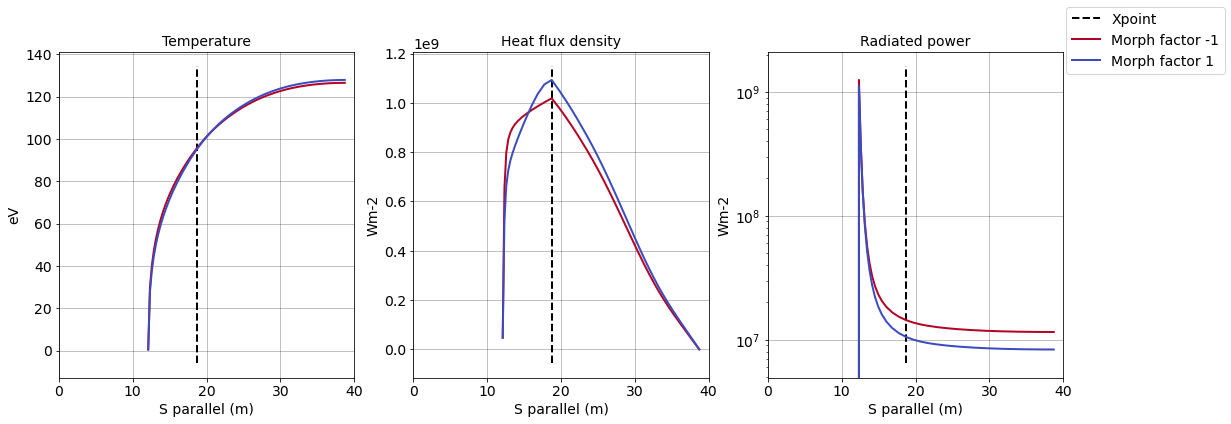

In [80]:
fig, axes = plt.subplots(1,3, figsize=(18,6))
Front = -2
store_colors = dict(zip(morphdata.keys(),make_colors(len(list_morph), plt.get_cmap("coolwarm"))[::-1]))

for case in ["ou_m0", "ou_m8"]:

    o = morph_study_kAr[case]["out"][0]
    morph = morphdata[case]["morph"]
    
    ax = axes[0]
    ax.plot(o["Sprofiles"][Front], o["Tprofiles"][Front], color = store_colors[case], linewidth = 2)
    ax.set_title("Temperature")
    ax.set_ylabel("eV")

    ax = axes[1]
    ax.plot(o["Sprofiles"][Front], o["Qprofiles"][Front], color = store_colors[case], linewidth = 2)
    ax.set_title("Heat flux density")
    ax.set_ylabel("Wm-2")
    
    ax = axes[2]
    ax.plot(o["Sprofiles"][Front], o["Rprofiles"][Front], label = f"Morph factor {morph}", color = store_colors[case], linewidth = 2)
    ax.set_title("Radiated power")
    ax.set_ylabel("Wm-2")
    ax.set_yscale("log")

for i, ax in enumerate(axes):
    ylims = ax.get_ylim()
    if i == 0:
        ax.vlines(morphdata[case]["S"][morphdata[case]["Xpoint"]], ylims[0], ylims[1], color = "black", label = "Xpoint", linewidth = 2, linestyle = "dashed")
    else:
        ax.vlines(morphdata[case]["S"][morphdata[case]["Xpoint"]], ylims[0], ylims[1], color = "black", linewidth = 2, linestyle = "dashed")
    ax.grid(color="black", alpha = 0.3)
    ax.set_xlabel("S parallel (m)")
    ax.set_xlim(0,40)
    
fig.legend(bbox_to_anchor=(1.03,1))

## Profiles

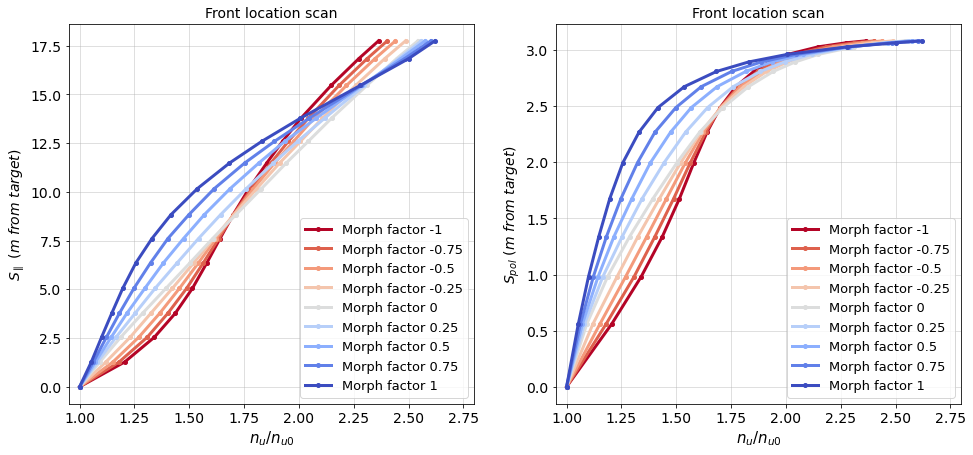

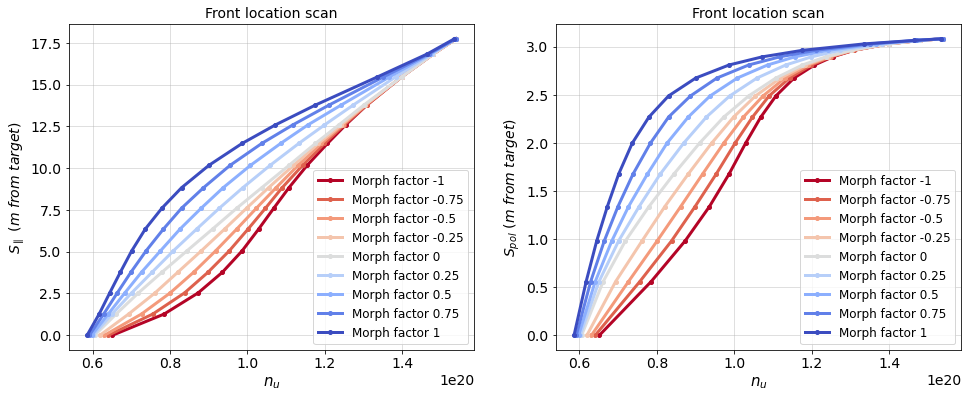

In [20]:
fig, axes = plt.subplots(1,2, figsize = (16,7))

ax = axes[0]
for i, side in enumerate(list_morph):
    o = morph_study_kAr[f"ou_m{i}"]["out"][0]
    ax.plot(o["crel"], o["Splot"], label = "Morph factor {}".format(side), linewidth = 3, marker = "o", markersize = 4, color = colors[i])
ax.set_ylabel("$S_{\parallel}\ (m\ from\ target)$")

ax = axes[1]
for i, side in enumerate(list_morph):
    o = morph_study_kAr[f"ou_m{i}"]["out"][0]
    ax.plot(o["crel"], o["SpolPlot"], label = "Morph factor {}".format(side), linewidth = 3, marker = "o", markersize = 4, color = colors[i])
ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")

for ax in axes:
    ax.grid(alpha = 0.5)
    ax.set_xlim(0.95, 2.80)
    ax.legend(fontsize = 13)
    ax.set_title("Front location scan")
    ax.set_xlabel("$n_{u}$/$n_{u0}$", fontsize = 15)
    
fig, axes = plt.subplots(1,2, figsize = (16,6))

ax = axes[0]
for i, side in enumerate(list_morph):
    o = morph_study_kAr[f"ou_m{i}"]["out"][0]
    ax.plot(o["cvar"], o["Splot"], label = "Morph factor {}".format(side), linewidth = 3, marker = "o", markersize = 4, color = colors[i])
ax.set_ylabel("$S_{\parallel}\ (m\ from\ target)$")

ax = axes[1]
for i, side in enumerate(list_morph):
    o = morph_study_kAr[f"ou_m{i}"]["out"][0]
    ax.plot(o["cvar"], o["SpolPlot"], label = "Morph factor {}".format(side), linewidth = 3, marker = "o", markersize = 4, color = colors[i])
ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")

for ax in axes:
    ax.grid(alpha = 0.5)
    # ax.set_xlim(0.95, 2.80)
    ax.legend(fontsize = 12)
    ax.set_title("Front location scan")
    ax.set_xlabel("$n_{u}$", fontsize = 15)


# 2D sensitivity plot

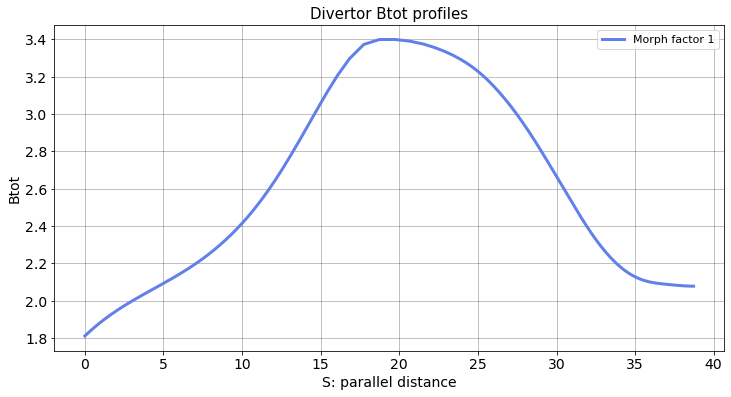

In [239]:
fig, ax = plt.subplots(figsize=(12,6))
# ax.plot(d["S"], d["Btot"],  linewidth = 2, linestyle = "solid", label = "Outer-Upper", zorder = 0, markersize = 0, color = "black", marker = "o")


colors = make_colors(len(list_morph), plt.get_cmap("coolwarm"))[::-1]

i = 7
d = morphdata[f"ou_m{i}"]
o = morph_study_kAr[f"ou_m{i}"]["out"][0]

ax.plot(d["S"], d["Btot"], linewidth = 3, linestyle = "solid", zorder = 5, label = f"Morph factor {morph}", marker = "o", alpha = 1, markersize = 0, color = colors[i])


ax.set_title("Divertor Btot profiles", fontsize = 15)
ax.legend(fontsize = 11)
ax.set_xlabel("S: parallel distance"); 
ax.set_ylabel("Btot")
ax.grid(color = "black", alpha = 0.3)

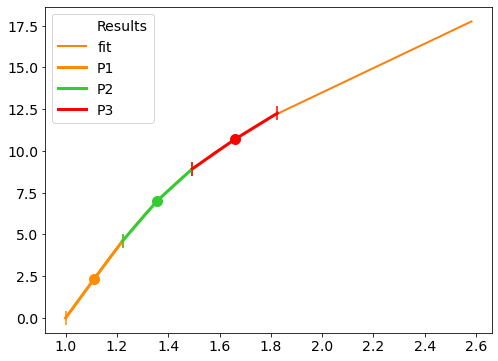

In [278]:
crel = np.array(o["crel"])
splot = np.array(o["Splot"])

def make_bands(o, d):
    # Out must contain crel, splot, spolplot in top level
    # Data must contain S, Spol, R, Z in top level

    bands = dict()
    # bands[param][band][subpoint]

    for param in ["C", "Spar", "S", "Spol", "R", "Z"]:
        bands[param] = np.array([None]*3) # Three bands
    for param in ["Spar", "S", "Spol", "R", "Z"]:
        for i in range(3):
            bands[param][i] = np.array([None]*3) # Three points in each band

    # Make continuous function returning S parallel for a given control variable
    interp = interpolate.UnivariateSpline(o["crel"], o["Splot"], k= 5)

    # P1: target, P3 = Xpoint
    frac = 0.1

    def make_band(start, frac):
        band = [start, start/(1-frac), (start/(1-frac)) * (1+frac)]
        return np.array(band)

    colors = ["darkorange", "limegreen", "red"]

    # Get the bands in control variable space
    bands["C"][0] = make_point(crel[0], frac)
    bands["C"][1] = make_point(C1[-1], frac)
    bands["C"][2] = make_point(C2[-1], frac)

    # Find corresponding S parallel 
    for band in range(3):
        for point in range(3):
            bands["S"][band][point] = interp(bands["C"][band][point])

    # Find corresponding R and Z by using index of closest S 
    for band in range(3):
        for point in range(3):
            Sindex = np.argmin(np.abs(d["S"] - S[band][point]))
            bands["Spol"][band][point] = d["Spol"][Sindex]
            bands["R"][band][point] = d["R"][Sindex]
            bands["Z"][band][point] = d["Z"][Sindex]
            
    return bands
    
bands = make_bands(o,d)


fig, ax = plt.subplots(figsize=(8,6))
ax.plot(crel, splot, marker = "o", linewidth = 0, markersize = 0, label = "Results", zorder = 1, alpha = 0.5)
ax.plot(crel, interp(crel), linewidth = 2, label = "fit", zorder = 0)

for i, key in enumerate(C.keys()):
    ax.plot(C[key], S[key], markersize = 10, label = "P{}".format(i+1), linewidth = 3, color = colors[i])
    ax.scatter(C[key][1], S[key][1], s = 100, marker = "o", color = colors[i])
    ax.scatter(C[key][0], S[key][0], s = 200, marker = "|", color = colors[i])
    ax.scatter(C[key][2], S[key][2], s = 200, marker = "|", color = colors[i])
# # ax.plot(C2, S2,  markersize = 10, color = "green", label = "P2", linewidth = 3)
# ax.plot(C3, S3,  markersize = 10, color = "blue", label = "P2", linewidth = 3)

ax.legend()

## Now find the closest R and Z to those S coordinates

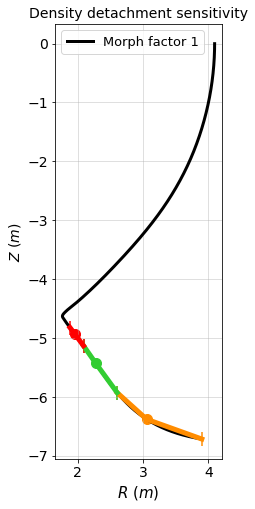

In [279]:
fig, ax = plt.subplots(figsize = (3,8))

# o = morph_study["ou"]["out"][0]
# ax.plot(o["crel"], o["Splot"], label = "Baseline", linewidth = 3, marker = "o", markersize = 4, color = "black")

i = 7
o = morph_study_kAr[f"ou_m{i}"]["out"][0]
d = morphdata[f"ou_m{i}"]
ax.plot(d["R"], d["Z"]*-1, label = "Morph factor 1".format(side), linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)
    
ax.set_xlabel("$R\ (m)$", fontsize = 15)
ax.set_ylabel("$Z\ (m)$")
ax.grid(alpha = 0.5)
ax.legend(fontsize = 13)
ax.set_title("Density detachment sensitivity")

for point in range(3):
    ax.plot(bands["R"][point], bands["Z"][point]*-1, markersize = 10, label = "P{}".format(point+1), linewidth = 5, color = colors[point])
    ax.scatter(bands["R"][point][1], -bands["Z"][point][1], s = 100, marker = "o", color = colors[point])
    ax.scatter(bands["R"][point][0], -bands["Z"][point][0], s = 200, marker = "|", color = colors[point])
    ax.scatter(bands["R"][point][2], -bands["Z"][point][2], s = 200, marker = "|", color = colors[point])


# Find smallest band

In [8]:
band = dict()

def band_width(S, interp):
    size = 0.05
    return interp(S)*(1+size) / interp(S)*(1-size)
    

In [ ]:
# size = 0.05
# start = interp(c_start)
# middle = interp(c_start/(1-size))
# end = interp(c_middle*(1+size))
# --> end = interp(c_start/(1-size)*(1+size))


NameError: name 's_interp' is not defined

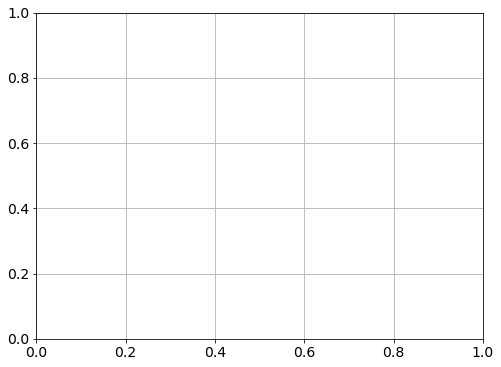

In [9]:
for k, side in enumerate(list_morph):

    # i = 0
    d = morphdata[f"ou_m{k}"]
    o = morph_study_kAr[f"ou_m{k}"]["out"][0]

    crel = np.array(o["crel"])
    splot = np.array(o["Splot"])
    spolplot = np.array(o["SpolPlot"])

    c_grid = np.linspace(crel[0], crel[-1], 1000)

    spar_interp = interpolate.UnivariateSpline(crel, splot, k= 5)
    spol_interp = interpolate.UnivariateSpline(crel, spolplot, k= 5)

    size = 0.05

    band_widths = []
    for i, c_start in enumerate(c_grid):
        c_middle = c_start/(1-size)
        c_end = c_middle*(1+size)

        spar_start = spar_interp(c_start)
        spar_middle = spar_interp(c_middle)
        spar_end = spar_interp(c_end)

        spol_start = spol_interp(c_start)
        spol_middle = spol_interp(c_middle)
        spol_end = spol_interp(c_end)

        # band_widths.append(s_end - s_start)
        # band_widths.append(interp(c_start/(1-size)*(1+size)) - interp(c_start))
        # band_width = spol_end - spol_start
        band_width = spar_end - spar_start

        if band_width <= 0:
            band_widths.append(np.nan)
        elif spol_end > spolplot[-1]:
            band_widths.append(np.nan)
        else:
            band_widths.append(band_width)

        # band_widths.append(band_width)

    fig, ax = plt.subplots()
    ax.plot(s_interp, band_widths, label = k)
    ax.set_xlabel("S parallel (m)")
    ax.set_ylabel("Band width (m)")
    # band_width(2, interp)

## Function to find and plot one band

In [18]:
k = 4
d = morphdata[f"ou_m{k}"]
o = morph_study_kAr[f"ou_m{k}"]["out"][0]

def make_window_band(d, o, spol_middle):
    
    o = copy.deepcopy(o)
    d = copy.deepcopy(d)
    size = 0.05
    crel = np.array(o["crel"])
    splot = np.array(o["Splot"])
    spolplot = np.array(o["SpolPlot"])
    Btot = d["Btot"]
    Btot_grad = np.gradient(Btot)

    c_grid = np.linspace(crel[0], crel[-1], 1000)

    spar_from_crel = interpolate.UnivariateSpline(crel, splot, k= 5)
    spol_from_crel = interpolate.UnivariateSpline(crel, spolplot, k= 5)
    crel_from_spol = interpolate.UnivariateSpline(spolplot, crel, k= 5)

    c_middle = crel_from_spol(spol_middle)
    
    band["C"] = [None] * 3
    band["C"][0] = c_middle * (1-size)
    band["C"][1] = c_middle
    band["C"][2] = c_middle * (1+size)

    for param in ["Spar", "Spol", "index", "R", "Z", "Btot"]:
        band[param] = np.array([float]*3)

    for i in range(3):
        band["Spar"][i] = spar_from_crel(band["C"][i])    
        band["Spol"][i] = spol_from_crel(band["C"][i])
        band["index"][i] = np.argmin(np.abs(d["S"] - band["Spar"][i]))
        band["R"][i] = d["R"][band["index"][i]]
        band["Z"][i] = d["Z"][band["index"][i]]
        band["Btot"][i] = d["Btot"][band["index"][i]]
        
    band["width_pol"] = band["Spol"][2] - band["Spol"][0]
    band["width_par"] = band["Spar"][2] - band["Spar"][0]
    band["Btot_avg"] = np.mean(Btot[band["index"][0]:band["index"][2]])
    band["Btot_grad_avg"] = np.mean(Btot_grad[band["index"][0]:band["index"][2]])

    return band


## Plot band on RZ space and poloidal Btot plot

(0.0, 4.0)

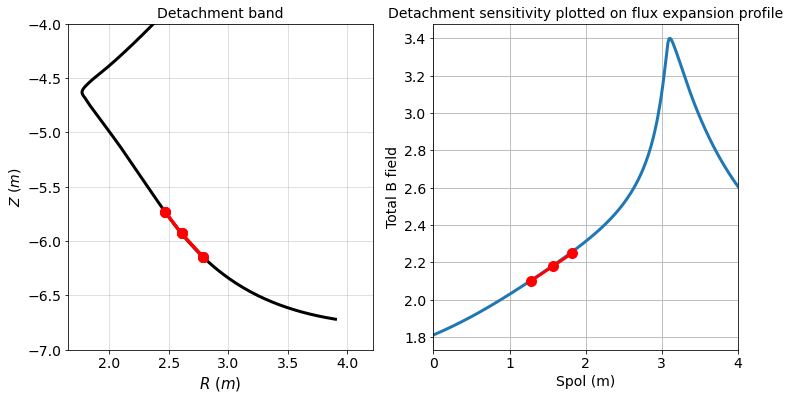

In [11]:
fig, axes = plt.subplots(1,2, figsize = (12,6))
k = 6
d = morphdata[f"ou_m{k}"]
o = morph_study_kAr[f"ou_m{k}"]["out"][0]

band = make_window_band(d, o, 1.5)

ax = axes[0]
ax.plot(d["R"], d["Z"]*-1, label = "Morph factor 1".format(side), linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)
ax.set_xlabel("$R\ (m)$", fontsize = 15)
ax.set_ylabel("$Z\ (m)$")
ax.set_ylim(-7, -4)
ax.grid(alpha = 0.5)
# ax.legend(fontsize = 13)
ax.set_title("Detachment band")
color = "red"
for point in range(3):
    ax.plot(band["R"], band["Z"]*-1, markersize = 10, marker = "o", linewidth = 3, color = color)
    # ax.scatter(band["R"][1], -band["Z"][1], s = 100, marker = "o", color = color)
    # ax.scatter(band["R"][0], -band["Z"][0], s = 100, marker = "x", color = color)
    # ax.scatter(band["R"][2], -band["Z"][2], s = 100, marker = "x", color = color)
ax = axes[1]
ax.plot(d["Spol"], d["Btot"]); ax.plot(band["Spol"], band["Btot"], marker = "o", color = color, markersize = 10, linewidth = 3); ax.set_xlabel("Spol (m)"); ax.set_ylabel("Total B field")
ax.set_title("Detachment sensitivity plotted on flux expansion profile")
ax.set_xlim(0,4)

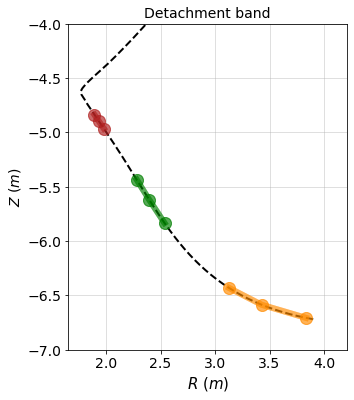

In [51]:
fig, ax = plt.subplots(1, figsize = (5,6))
k = 6
d = morphdata[f"ou_m{k}"]
o = morph_study_kAr[f"ou_m{k}"]["out"][0]

band1 = make_window_band(d, o, 0.5)
band2 = make_window_band(d, o, 1.5)
band3 = make_window_band(d, o, 3)

ax.plot(d["R"], d["Z"]*-1, label = "Morph factor 1".format(side), linewidth = 2, linestyle = "dashed", marker = "o", markersize = 0, color = "black", alpha = 1)
ax.set_xlabel("$R\ (m)$", fontsize = 15)
ax.set_ylabel("$Z\ (m)$")
ax.set_ylim(-7, -4)
ax.grid(alpha = 0.5)
# ax.legend(fontsize = 13)
ax.set_title("Detachment band")

spol1 = 0.1
spol2 = 1.8
spol3 = 2.8

alpha = 0.3
for point in range(3):
    ax.plot(make_window_band(d, o, spol1)["R"], make_window_band(d, o, spol1)["Z"]*-1, markersize = 12, marker = "o", linewidth = 6, color = "darkorange", alpha = alpha)
    ax.plot(make_window_band(d, o, spol2)["R"], make_window_band(d, o, spol2)["Z"]*-1, markersize = 12, marker = "o", linewidth = 6, color = "green", alpha = alpha)
    ax.plot(make_window_band(d, o, spol3)["R"], make_window_band(d, o, spol3)["Z"]*-1, markersize = 12, marker = "o", linewidth = 6, color = "firebrick", alpha = alpha)
    # ax.scatter(band["R"][1], -band["Z"][1], s = 100, marker = "o", color = color)
    # ax.scatter(band["R"][0], -band["Z"][0], s = 100, marker = "x", color = color)
    # ax.scatter(band["R"][2], -band["Z"][2], s = 100, marker = "x", color = color)

fig.savefig("fig25A.svg", format="svg", dpi=1200)
fig.savefig("fig25A.png", format="png", dpi=1200)

In [27]:
band1 = make_window_band(d, o, 0.5)
band2 = make_window_band(d, o, 3)

print(band1["Z"])
print(band2["Z"])

[4.740208790205598 4.711352075449022 4.682046291961553]
[4.740208790205598 4.711352075449022 4.682046291961553]


In [26]:
print(make_window_band(d, o, 0.5)["Z"])
print(make_window_band(d, o, 3)["Z"])

[6.627354491932836 6.474831387657302 6.300638792446126]
[4.740208790205598 4.711352075449022 4.682046291961553]


## Plot band width minima across S poloidal

Text(0, 0.5, '5% Density detachment band width (m)')

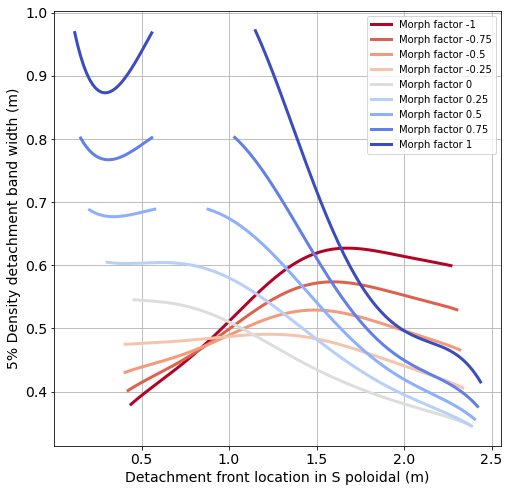

In [6]:
fig, ax = plt.subplots(figsize = (8,8))
widths = dict()
Btot_avg = dict()
Btot_grad_avg = dict()

for k in range(9):
    # k = 6
    d = morphdata[f"ou_m{k}"]
    o = morph_study_kAr[f"ou_m{k}"]["out"][0]

    Xpoint = d["Xpoint"]
    Spolx = d["Spol"][Xpoint]
    Spol = d["Spol"]

    Spol_lims = [Spolx*0.1, Spolx*0.8]
    widths[k] = []
    Btot_avg[k] = []
    Btot_grad_avg[k] = []

    for s in Spol[:Xpoint]:

        band = make_window_band(d,o,s)
        if \
        band["Spol"][0] < Spol_lims[0] or \
        band["Spol"][2] > Spol_lims[1] or \
        band["width_pol"] < 0:
            widths[k].append(np.nan)
            Btot_avg[k].append(np.nan)
            Btot_grad_avg[k].append(np.nan)
        else:
            widths[k].append(band["width_pol"])
            Btot_avg[k].append(band["Btot_avg"])
            Btot_grad_avg[k].append(band["Btot_grad_avg"])        

    ax.plot(Spol[:Xpoint], widths[k], label = "Morph factor {}".format(list_morph[k]), color = colors[k])
    
ax.legend(fontsize = 10)
ax.set_xlabel("Detachment front location in S poloidal (m)"); ax.set_ylabel("5% Density detachment band width (m)")

In [23]:
Sx

18.733864814291962

## Plot minimum band in RZ space

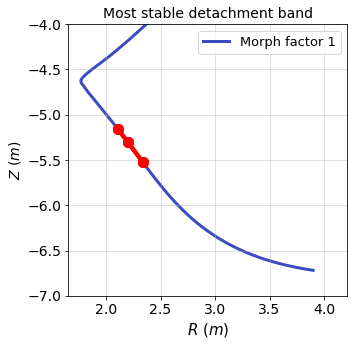

In [733]:
k = 8
colors = make_colors(len(list_morph), plt.get_cmap("coolwarm"))[::-1]

fig, ax = plt.subplots(figsize=(5,5))
d = morphdata[f"ou_m{k}"]
o = morph_study_kAr[f"ou_m{k}"]["out"][0]

ax.plot(d["R"], d["Z"]*-1, label = "Morph factor {}".format(list_morph[k]), linewidth = 3, marker = "o", markersize = 0, color = colors[k], alpha = 1, zorder = 0)

ax.set_xlabel("$R\ (m)$", fontsize = 15)
ax.set_ylabel("$Z\ (m)$")
ax.grid(alpha = 0.5)
ax.set_ylim(-7,-4)
ax.legend(fontsize = 13)
ax.set_title("Most stable detachment band")

min_width = np.nanmin(widths[k])
min_Spol = d["Spol"][np.where(widths[k] == min_width)]

band = make_window_band(d, o, min_Spol)
# band = make_window_band(d, o, 0.5)
color = "red"
for point in range(3):
    ax.plot(band["R"], band["Z"]*-1, markersize = 10, marker = "o", linewidth = 4, color = color)
    # ax.scatter(band["R"][1], -band["Z"][1], s = 100, marker = "o", color = color)
    # ax.scatter(band["R"][0], -band["Z"][0], s = 100, marker = "x", color = color)
    # ax.scatter(band["R"][2], -band["Z"][2], s = 100, marker = "x", color = color)


## Plot band width minima in RZ space

(-7.0, -4.0)

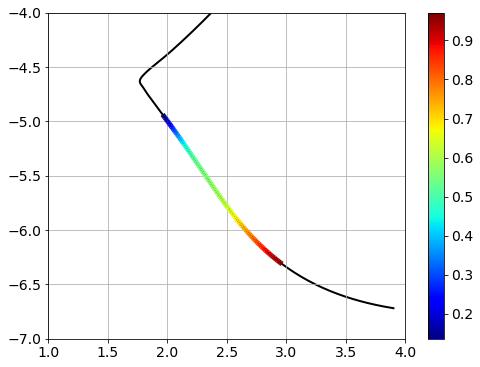

In [670]:
# Create a continuous norm to map from data points to colors
d = morphdata[f"ou_m{k}"]
o = morph_study_kAr[f"ou_m{k}"]["out"][0]
x = d["R"][:Xpoint]
y = d["Z"][:Xpoint] * -1
dydx = np.array(widths[k])

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots()

ax.plot(d["R"], d["Z"]*-1, label = "Morph factor 1".format(side), 
        linewidth = 2, marker = "o", markersize = 0, color = "black", alpha = 1, zorder = 0)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(np.nanmin(dydx), np.nanmax(dydx))
lc = LineCollection(segments, cmap='jet', norm=norm)
# Set the values used for colormapping
lc.set_array(dydx)
lc.set_linewidth(5)
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax)
ax.set_xlim(1,4)
ax.set_ylim(-7,-4)


## Plot relationship between band width and B gradient

Text(0, 0.5, 'Detachment band width (m poloidal)')

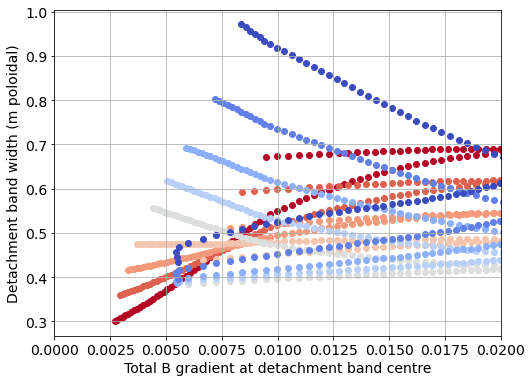

In [855]:
fig, ax = plt.subplots()

for k, side in enumerate(list_morph):
    ax.scatter(np.gradient(d["Btot"])[:Xpoint], widths[k], color = colors[k])
    # ax.scatter(Btot_avg[k], widths[k], color = colors[k])
ax.set_xlim(0,0.02)
ax.set_xlabel("Total B gradient at detachment band centre")
ax.set_ylabel("Detachment band width (m poloidal)")

## Plot continuous band minima on Btot profiles

In [25]:
all_widths = []
for k in range(len(list_morph)):
    all_widths.append(widths[k])
    
all_widths = np.array(all_widths)
global_min = np.nanmin(all_widths)
global_max = np.nanmax(all_widths)

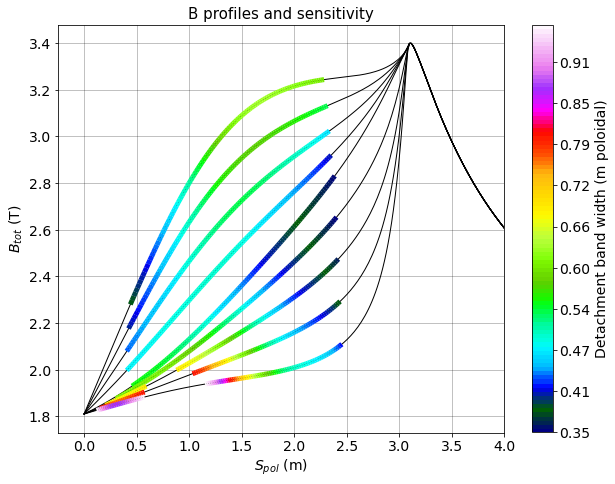

In [31]:
fig, ax = plt.subplots(figsize=(10,7.5))
# ax.plot(d["Spol"], d["Btot"],  linewidth = 2, linestyle = "solid", label = "Outer-Upper", zorder = 0, markersize = 0, color = "black", marker = "o")


colors = make_colors(len(list_morph), plt.get_cmap("coolwarm"))[::-1]
# colors = [plt.get_cmap("Dark2")(x) for x in range(len(list_morph))]

for k, morph in enumerate(list_morph):#[-1, -0.5, 0, 0.3, 0.5]:
    d = morphdata[f"ou_m{k}"]
    o = morph_study_kAr[f"ou_m{k}"]["out"][0]
    x = d["Spol"][:Xpoint]
    y = d["Btot"][:Xpoint]
    dydx = np.array(widths[k])
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(global_min, global_max)
    lc = LineCollection(segments, cmap='gist_ncar', norm=norm)
    # Set the values used for colormapping
    lc.set_array(dydx)
    lc.set_linewidth(5)
    line = ax.add_collection(lc)
    # fig.colorbar(line, ax=ax)

    ax.plot(morphdata[f"ou_m{k}"]["Spol"], morphdata[f"ou_m{k}"]["Btot"], linewidth = 1, linestyle = "solid", zorder = 0, label = f"Morph factor {morph}", marker = "o", alpha = 1, markersize = 0, color = "black")

ylims = ax.axes.get_ylim()

norm = mpl.colors.BoundaryNorm(np.linspace(global_min, global_max, 100), plt.get_cmap("gist_ncar").N)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap("gist_ncar")),  orientation="vertical", label = "Detachment band width (m poloidal)")
cb.ax.set_yticklabels(["{:.2f}".format(i) for i in cb.get_ticks()]) 

ax.set_title("B profiles and sensitivity", fontsize = 15)
# ax.legend(fontsize = 11)
ax.set_xlim(-0.25, 4)
ax.set_xlabel("$S_{pol}$ (m)"); 
ax.set_ylabel("$B_{tot}$ (T)")
ax.grid(color = "black", alpha = 0.3)

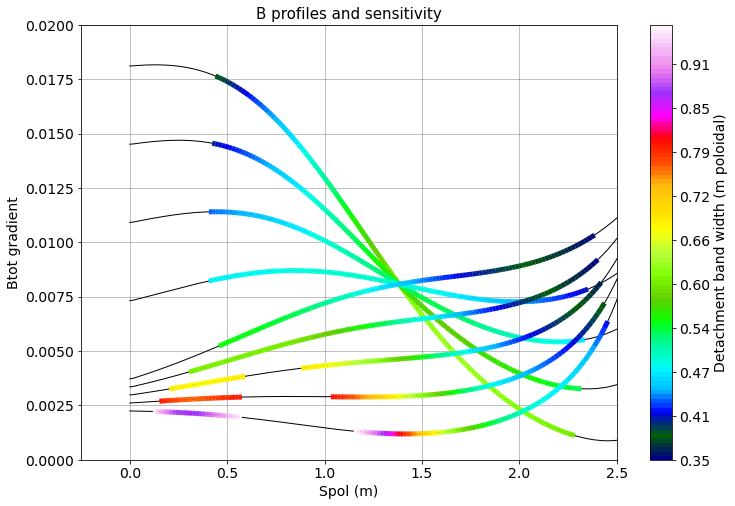

In [33]:
fig, ax = plt.subplots(figsize=(12,8))
# ax.plot(d["Spol"], d["Btot"],  linewidth = 2, linestyle = "solid", label = "Outer-Upper", zorder = 0, markersize = 0, color = "black", marker = "o")


colors = make_colors(len(list_morph), plt.get_cmap("coolwarm"))[::-1]
# colors = [plt.get_cmap("Dark2")(x) for x in range(len(list_morph))]

for k, morph in enumerate(list_morph):#[-1, -0.5, 0, 0.3, 0.5]:
    d = morphdata[f"ou_m{k}"]
    o = morph_study_kAr[f"ou_m{k}"]["out"][0]
    x = d["Spol"][:Xpoint]
    y = np.gradient(d["Btot"][:Xpoint] )
    dydx = np.array(widths[k])
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(global_min, global_max)
    lc = LineCollection(segments, cmap='gist_ncar', norm=norm)
    # Set the values used for colormapping
    lc.set_array(dydx)
    lc.set_linewidth(5)
    line = ax.add_collection(lc)
    # fig.colorbar(line, ax=ax)

    ax.plot(morphdata[f"ou_m{k}"]["Spol"], np.gradient(morphdata[f"ou_m{k}"]["Btot"]), linewidth = 1, linestyle = "solid", zorder = 0, label = f"Morph factor {morph}", marker = "o", alpha = 1, markersize = 0, color = "black")

ylims = ax.axes.get_ylim()

norm = mpl.colors.BoundaryNorm(np.linspace(global_min, global_max, 100), plt.get_cmap("gist_ncar").N)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap("gist_ncar")),  orientation="vertical", label = "Detachment band width (m poloidal)")
cb.ax.set_yticklabels(["{:.2f}".format(i) for i in cb.get_ticks()]) 

ax.set_title("B profiles and sensitivity", fontsize = 15)
# ax.legend(fontsize = 11)
# ax.set_xlim(-0.25, 4)
ax.set_xlim(-0.25, 2.5)
ax.set_ylim(0,0.02)
ax.set_xlabel("Spol (m)"); 
ax.set_ylabel("Btot gradient")
ax.grid(color = "black", alpha = 0.3)

# Make profile with band in middle

In [373]:
(c_middle - c_start)/c_middle

0.04999999999999998

(0.0, 4.0)

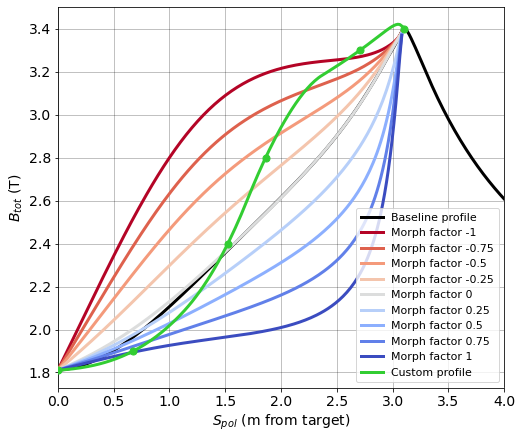

In [31]:
d = data["ou"]
controls = [0, d["Xpoint"]]
controls = np.linspace(0, d["Xpoint"], 4).astype(int)
controls = np.insert(controls, -1, int(controls[-1]-6))
controls = [0, 40, 90, 110, 160, d["Xpoint"]]

leg_x = d["S"][:d["Xpoint"]+1] # Plus 1 because otherwise it doesnt include Xpoint itself
x_base = d["S"][(controls)]
x_pol_base = d["Spol"][(controls)]
y_base = d["Btot"][(controls)]
Bx = d["Btot"][d["Xpoint"]]
Bt = d["Btot"][0]
Sx = d["S"][d["Xpoint"]]

y_fit_base = interpolate.InterpolatedUnivariateSpline(x_base,y_base)(leg_x)            

# when morph = 1, points line up with Xpoint. when morph = 0, line up with target
def adjust(array, index, morph, mod):
    if morph != 0:  
        if morph > 0:
            distance = Bt - array[index]
        if morph < 0:
            distance = Bx - array[index]  
        array[index] += distance*abs(morph * mod)
    return array
    
fig, ax = plt.subplots(figsize=(8,7))
ax.plot(d["Spol"], d["Btot"],  linewidth = 3, linestyle = "solid", label = "Baseline profile", zorder = 0, markersize = 0, color = "black", marker = "o")
Xpoint = morphdata["ou_m0"]["Xpoint"]

morphdata2 = dict()

for k, morph in enumerate(list_morph):#[-1, -0.5, 0, 0.3, 0.5]:
    ax.plot(morphdata[f"ou_m{k}"]["Spol"][:Xpoint], morphdata[f"ou_m{k}"]["Btot"][:Xpoint], linewidth = 3, linestyle = "solid", zorder = 5, label = f"Morph factor {morph}", marker = "o", alpha = 1, markersize = 0, color = colors[k])

morph = -1

y_morph = np.array([1.81066218, 1.9, 2.4, 2.8, 3.3, 3.39821949])
y_fit_morph = interpolate.InterpolatedUnivariateSpline(x_base,y_morph, k = 2)(leg_x) 
Btot_new = np.concatenate([y_fit_morph, d["Btot"][d["Xpoint"]+1:]])

morphdata2 = copy.deepcopy(morphdata)
morphdata2["custom"] = copy.deepcopy(morphdata2["ou_m1"])
morphdata2["custom"]["Btot"] = Btot_new
morphdata2["custom"]["morph"] = "Custom"


ax.plot(morphdata[f"ou_m{k}"]["Spol"][:Xpoint], Btot_new[:Xpoint], linewidth = 3, linestyle = "solid", zorder = 10, label = f"Custom profile", marker = "o", alpha = 1, markersize = 0, color = "limegreen")
ax.scatter(x_pol_base, y_morph, zorder = 11, color = "limegreen", s = 50)
ylims = ax.axes.get_ylim()

# ax.set_title("Profiles - poloidal", fontsize = 15)
ax.legend(fontsize = 11)
ax.set_xlabel("$S_{pol}$ (m from target)"); 
ax.set_ylabel("$B_{tot}$ (T)")
ax.grid(color = "black", alpha = 0.3)
ax.set_xlim(0,4)


## Run

### Density

In [8]:
morph_study_kAr2 = dict()

for side in morphdata2.keys():
    print("Solving side", side)
    out = []
    results = dict()
    
    for param in ["window", "threshold", "window_ratio"]:
        results[param] = []


    d = morphdata2[side].copy()
    i = 0
    
    constants = constants_default.copy()
    radios = radios_default.copy()
    indexRange = np.linspace(0, d["Xpoint"]-1, 15).astype(int)
    radios["upstreamGrid"] = True
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    constants["Lfunc"] = LfuncKallenbachAr
    out.append(LRBv2(constants,radios,d["S"],indexRange, 
                                        Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 1, verbosity = 0,
                                        control_variable = "density"))

    out[i]["SpolPlot"] = [d["Spol"][x] for x in indexRange]
    results["window"].append(out[i]["cvar"][-1] - out[i]["cvar"][0])
    results["window_ratio"].append(out[i]["cvar"][-1] / out[i]["cvar"][0])
    results["threshold"].append(out[i]["cvar"][0])
    results["indexRange"] = indexRange
    results["constants"] = constants
    results["radios"] = radios
    results["out"] = out
    
    # Take out any thresholds for a window ratio < 1
    for i, x in enumerate(results["threshold"]):
        if results["window_ratio"][i] < 1:
            results["threshold"][i] = np.nan
    try:
        results["rel_threshold"] = results["threshold"] / max([x for x in results["threshold"] if ~np.isnan(x)])
    except:
        pass
    morph_study_kAr2[side] = results.copy()

Solving side ou_m0
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 19.2 seconds
Solving side ou_m1
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 17.7 seconds
Solving side ou_m2
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 17.7 seconds
Solving side ou_m3
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 17.6 seconds
Solving side ou_m4
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 16.6 seconds
Solving side ou_m5
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 19.8 seconds
Solving side ou_m6
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 18.8 seconds
Solving side ou_m7
Solving...0...13...26...39...52...65

### Impurity

In [80]:
morph_study_kAr2_fi = dict()

for side in morphdata2.keys():
    print("Solving side", side)
    out = []
    results = dict()
    
    for param in ["window", "threshold", "window_ratio"]:
        results[param] = []


    d = morphdata2[side].copy()
    i = 0
    
    constants = constants_default.copy()
    radios = radios_default.copy()
    indexRange = np.linspace(0, d["Xpoint"]-1, 15).astype(int)
    radios["upstreamGrid"] = True
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    constants["Lfunc"] = LfuncKallenbachAr
    out.append(LRBv21(constants,radios,d["S"],d["Spol"],indexRange, 
                                        Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 1, verbosity = 0,
                                        control_variable = "impurity_frac"))

    out[i]["SpolPlot"] = [d["Spol"][x] for x in indexRange]
    results["window"].append(out[i]["cvar"][-1] - out[i]["cvar"][0])
    results["window_ratio"].append(out[i]["cvar"][-1] / out[i]["cvar"][0])
    results["threshold"].append(out[i]["cvar"][0])
    results["indexRange"] = indexRange
    results["constants"] = constants
    results["radios"] = radios
    results["out"] = out
    
    # Take out any thresholds for a window ratio < 1
    for i, x in enumerate(results["threshold"]):
        if results["window_ratio"][i] < 1:
            results["threshold"][i] = np.nan
    try:
        results["rel_threshold"] = results["threshold"] / max([x for x in results["threshold"] if ~np.isnan(x)])
    except:
        pass
    morph_study_kAr2_fi[side] = results.copy()

Solving side ou_m0
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 16.4 seconds
Solving side ou_m1
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 19.7 seconds
Solving side ou_m2
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 20.3 seconds
Solving side ou_m3
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 15.9 seconds
Solving side ou_m4
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 16.4 seconds
Solving side ou_m5
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 17.9 seconds
Solving side ou_m6
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 17.4 seconds
Solving side ou_m7
Solving...0...13...26...39...52...65

### Power reduction

In [90]:
morph_study_kAr2_q = dict()

for side in morphdata2.keys():
    print("Solving side", side)
    out = []
    results = dict()
    
    for param in ["window", "threshold", "window_ratio"]:
        results[param] = []


    d = morphdata2[side].copy()
    i = 0
    
    constants = constants_default.copy()
    radios = radios_default.copy()
    indexRange = np.linspace(0, d["Xpoint"]-1, 15).astype(int)
    radios["upstreamGrid"] = True
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    constants["Lfunc"] = LfuncKallenbachAr
    out.append(LRBv21(constants,radios,d["S"],d["Spol"],indexRange, 
                                        Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 1, verbosity = 0,
                                        control_variable = "power"))

    out[i]["SpolPlot"] = [d["Spol"][x] for x in indexRange]
    results["window"].append(out[i]["cvar"][-1] - out[i]["cvar"][0])
    results["window_ratio"].append(out[i]["cvar"][-1] / out[i]["cvar"][0])
    results["threshold"].append(out[i]["cvar"][0])
    results["indexRange"] = indexRange
    results["constants"] = constants
    results["radios"] = radios
    results["out"] = out
    
    # Take out any thresholds for a window ratio < 1
    for i, x in enumerate(results["threshold"]):
        if results["window_ratio"][i] < 1:
            results["threshold"][i] = np.nan
    try:
        results["rel_threshold"] = results["threshold"] / max([x for x in results["threshold"] if ~np.isnan(x)])
    except:
        pass
    morph_study_kAr2_q[side] = results.copy()

Solving side ou_m0
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 17.4 seconds
Solving side ou_m1
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 20.7 seconds
Solving side ou_m2
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 22.0 seconds
Solving side ou_m3
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 22.3 seconds
Solving side ou_m4
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 20.2 seconds
Solving side ou_m5
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 22.6 seconds
Solving side ou_m6
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 20.6 seconds
Solving side ou_m7
Solving...0...13...26...39...52...65

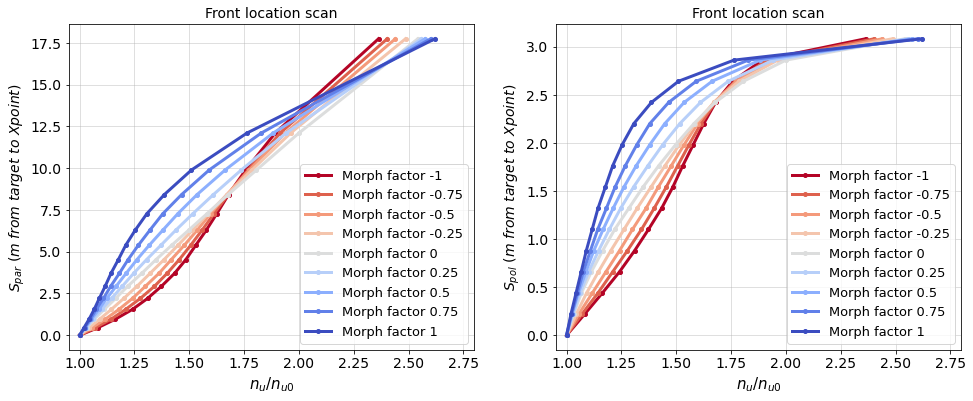

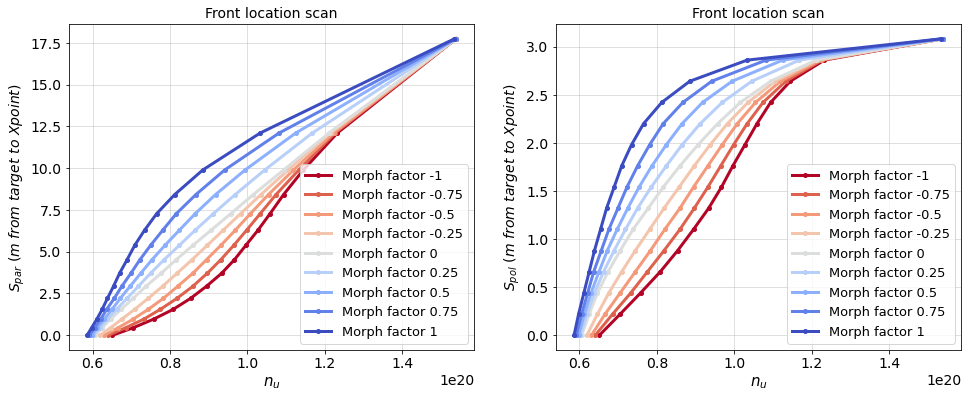

In [41]:
fig, axes = plt.subplots(1,2, figsize = (16,6))

ax = axes[0]
for i, side in enumerate(list_morph):
    o = morph_study_kAr2[f"ou_m{i}"]["out"][0]
    ax.plot(o["crel"], o["Splot"], label = "Morph factor {}".format(side), linewidth = 3, marker = "o", markersize = 4, color = colors[i])
ax.set_ylabel("$S_{par}\ (m\ from\ target\ to\ Xpoint)$")

ax = axes[1]
for i, side in enumerate(list_morph):
    o = morph_study_kAr2[f"ou_m{i}"]["out"][0]
    ax.plot(o["crel"], o["SpolPlot"], label = "Morph factor {}".format(side), linewidth = 3, marker = "o", markersize = 4, color = colors[i])
ax.set_ylabel("$S_{pol}\ (m\ from\ target\ to\ Xpoint)$")

for ax in axes:
    ax.grid(alpha = 0.5)
    ax.set_xlim(0.95, 2.80)
    ax.legend(fontsize = 13)
    ax.set_title("Front location scan")
    ax.set_xlabel("$n_{u}$/$n_{u0}$", fontsize = 15)
    
fig, axes = plt.subplots(1,2, figsize = (16,6))

ax = axes[0]
for i, side in enumerate(list_morph):
    o = morph_study_kAr2[f"ou_m{i}"]["out"][0]
    ax.plot(o["cvar"], o["Splot"], label = "Morph factor {}".format(side), linewidth = 3, marker = "o", markersize = 4, color = colors[i])
ax.set_ylabel("$S_{par}\ (m\ from\ target\ to\ Xpoint)$")

ax = axes[1]
for i, side in enumerate(list_morph):
    o = morph_study_kAr2[f"ou_m{i}"]["out"][0]
    ax.plot(o["cvar"], o["SpolPlot"], label = "Morph factor {}".format(side), linewidth = 3, marker = "o", markersize = 4, color = colors[i])
ax.set_ylabel("$S_{pol}\ (m\ from\ target\ to\ Xpoint)$")

for ax in axes:
    ax.grid(alpha = 0.5)
    # ax.set_xlim(0.95, 2.80)
    ax.legend(fontsize = 13)
    ax.set_title("Front location scan")
    ax.set_xlabel("$n_{u}$", fontsize = 15)


In [10]:
colors2 = colors.copy()
colors2.append("limegreen")
colors2
# colors2 = colors2.append("limegreen")

[(0.705673158, 0.01555616, 0.150232812, 1.0),
 (0.8696552305058823, 0.37927381945098043, 0.30094110221960785, 1.0),
 (0.9582793979254902, 0.604335096882353, 0.48329710138823534, 1.0),
 (0.9581760317411765, 0.7712340904, 0.6803010368117647, 1.0),
 (0.863391831290196, 0.8650837958196078, 0.8676338842627451, 1.0),
 (0.7189852929803922, 0.811992893745098, 0.9776561613921568, 1.0),
 (0.5488761722823529, 0.6851035851764705, 0.9943791404235295, 1.0),
 (0.3785982492705882, 0.5038562171921569, 0.9136916108470589, 1.0),
 (0.2298057, 0.298717966, 0.753683153, 1.0),
 'limegreen']

## Band width scans

C:\Apps\Anaconda3\envs\py38\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Apps\Anaconda3\envs\py38\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Apps\Anaconda3\envs\py38\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Apps\Anaconda3\envs\py38\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


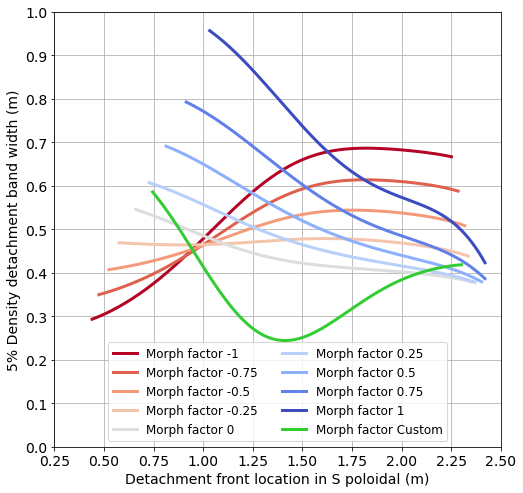

In [17]:
fig, ax = plt.subplots(figsize = (8,8))
widths2 = dict()
Btot_avg2 = dict()
Btot_grad_avg2 = dict()

for k, case in enumerate(morph_study_kAr2.keys()):
    # k = 6
    d = morphdata2[case]
    o = morph_study_kAr2[case]["out"][0]

    Xpoint = d["Xpoint"]
    Spolx = d["Spol"][Xpoint]
    Spol = d["Spol"]

    Spol_lims = [Spolx*0.1, Spolx*0.8]
    widths[k] = []
    Btot_avg[k] = []
    Btot_grad_avg[k] = []

    for s in Spol[:Xpoint]:

        band = make_window_band(d,o,s)
        if \
        band["Spol"][0] < Spol_lims[0] or \
        band["Spol"][2] > Spol_lims[1] or \
        band["width_pol"] < 0:
            widths[k].append(np.nan)
            Btot_avg[k].append(np.nan)
            Btot_grad_avg[k].append(np.nan)
        else:
            widths[k].append(band["width_pol"])
            Btot_avg[k].append(band["Btot_avg"])
            Btot_grad_avg[k].append(band["Btot_grad_avg"])        

    ax.plot(Spol[:Xpoint], widths[k], label = "Morph factor {}".format(d["morph"]), color = colors2[k])
    
ax.legend(fontsize = 12, ncol = 2, loc = "lower center")
ax.set_xlabel("Detachment front location in S poloidal (m)"); ax.set_ylabel("5% Density detachment band width (m)")
# ax.set_title("Locations of best detachment sensitivity")
ax.set_xlim(0.25,2.50)
ax.set_ylim(0,1)
ax.xaxis.set_major_locator(MultipleLocator(0.25))
ax.yaxis.set_major_locator(MultipleLocator(0.1))

In [97]:
Spolx

3.0977462538646985

## Impurity

C:\Apps\Anaconda3\envs\py38\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Apps\Anaconda3\envs\py38\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Apps\Anaconda3\envs\py38\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Apps\Anaconda3\envs\py38\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Apps\Anaconda3\envs\py38\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Apps\Anaconda3\envs\py38\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret

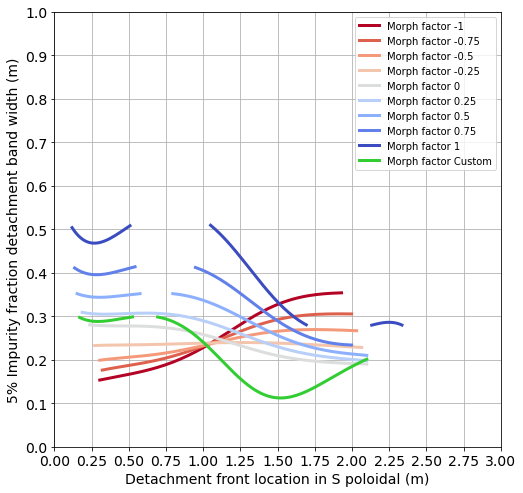

In [111]:
fig, ax = plt.subplots(figsize = (8,8))
widths2 = dict()
Btot_avg2 = dict()
Btot_grad_avg2 = dict()

for k, case in enumerate(morph_study_kAr2.keys()):
    # k = 6
    d = morphdata2[case]
    o = morph_study_kAr2_fi[case]["out"][0]

    Xpoint = d["Xpoint"]
    Spolx = d["Spol"][Xpoint]
    Spol = d["Spol"]

    Spol_lims = [Spolx*0.1, Spolx*0.7]
    widths[k] = []
    Btot_avg[k] = []
    Btot_grad_avg[k] = []

    for s in Spol[:Xpoint]:

        band = make_window_band(d,o,s, size = 0.05)
        if \
        band["Spol"][0] < Spol_lims[0] or \
        band["Spol"][2] > Spol_lims[1]:# or:  \
        band["width_pol"] < 0:
            widths[k].append(np.nan)
            Btot_avg[k].append(np.nan)
            Btot_grad_avg[k].append(np.nan)
        else:
            widths[k].append(band["width_pol"])
            Btot_avg[k].append(band["Btot_avg"])
            Btot_grad_avg[k].append(band["Btot_grad_avg"])        

    ax.plot(Spol[:Xpoint], widths[k], label = "Morph factor {}".format(d["morph"]), color = colors2[k])
    
ax.legend(fontsize = 10)
ax.set_xlabel("Detachment front location in S poloidal (m)"); ax.set_ylabel("5% Impurity fraction detachment band width (m)")
# ax.set_title("Locations of best detachment sensitivity")
ax.set_xlim(0,3)
ax.set_ylim(0,1)
ax.xaxis.set_major_locator(MultipleLocator(0.25))
ax.yaxis.set_major_locator(MultipleLocator(0.1))

## Power

C:\Apps\Anaconda3\envs\py38\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Apps\Anaconda3\envs\py38\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Apps\Anaconda3\envs\py38\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Apps\Anaconda3\envs\py38\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


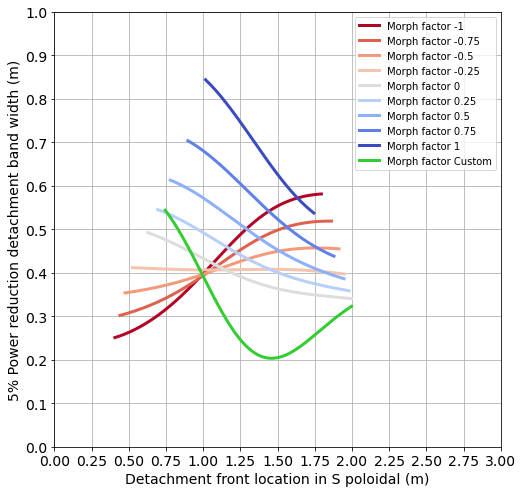

In [106]:
fig, ax = plt.subplots(figsize = (8,8))
widths2 = dict()
Btot_avg2 = dict()
Btot_grad_avg2 = dict()

for k, case in enumerate(morph_study_kAr2_q.keys()):
    # k = 6
    d = morphdata2[case]
    o = morph_study_kAr2_q[case]["out"][0]

    Xpoint = d["Xpoint"]
    Spolx = d["Spol"][Xpoint]
    Spol = d["Spol"]

    Spol_lims = [Spolx*0.1, Spolx*0.7]
    widths[k] = []
    Btot_avg[k] = []
    Btot_grad_avg[k] = []

    for s in Spol[:Xpoint]:

        band = make_window_band(d,o,s, size = 0.05, q= True)
        if \
        band["Spol"][0] < Spol_lims[0] or \
        band["Spol"][2] > Spol_lims[1] or \
        band["width_pol"] < 0:
            widths[k].append(np.nan)
            Btot_avg[k].append(np.nan)
            Btot_grad_avg[k].append(np.nan)
        else:
            widths[k].append(band["width_pol"])
            Btot_avg[k].append(band["Btot_avg"])
            Btot_grad_avg[k].append(band["Btot_grad_avg"])        

    ax.plot(Spol[:Xpoint], widths[k], label = "Morph factor {}".format(d["morph"]), color = colors2[k])
    
ax.legend(fontsize = 10)
ax.set_xlabel("Detachment front location in S poloidal (m)"); ax.set_ylabel("5% Power reduction detachment band width (m)")
# ax.set_title("Locations of best detachment sensitivity")
ax.set_xlim(0,3)
ax.set_ylim(0,1)
ax.xaxis.set_major_locator(MultipleLocator(0.25))
ax.yaxis.set_major_locator(MultipleLocator(0.1))

In [51]:
colors2

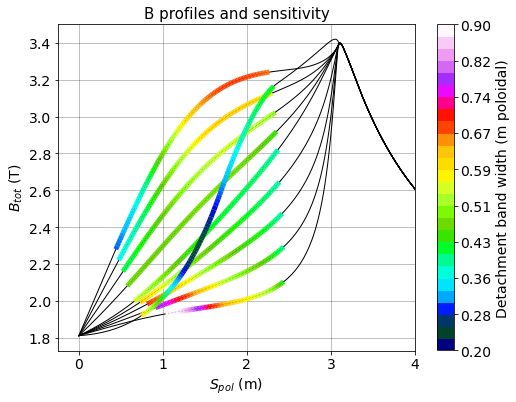

In [25]:
fig, ax = plt.subplots(figsize=(10*0.8,7.5*0.8))
# ax.plot(d["Spol"], d["Btot"],  linewidth = 2, linestyle = "solid", label = "Outer-Upper", zorder = 0, markersize = 0, color = "black", marker = "o")

    

global_min = 0.2
global_max = 0.9

colors = make_colors(len(list_morph), plt.get_cmap("coolwarm"))[::-1]
# colors = [plt.get_cmap("Dark2")(x) for x in range(len(list_morph))]

for k, case in enumerate(morph_study_kAr2):#[-1, -0.5, 0, 0.3, 0.5]:
    d = morphdata2[case]
    o = morph_study_kAr2[case]["out"][0]
    x = d["Spol"][:Xpoint]
    y = d["Btot"][:Xpoint]
    dydx = np.array(widths[k])
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(global_min, global_max)
    lc = LineCollection(segments, cmap='gist_ncar', norm=norm)
    # Set the values used for colormapping
    lc.set_array(dydx)
    lc.set_linewidth(5)
    line = ax.add_collection(lc)
    # fig.colorbar(line, ax=ax)

    ax.plot(morphdata2[case]["Spol"], morphdata2[case]["Btot"], linewidth = 1, linestyle = "solid", zorder = 0, label = "Morph factor {}".format(d["morph"]), marker = "o", alpha = 1, markersize = 0, color = "black")

ylims = ax.axes.get_ylim()

norm = mpl.colors.BoundaryNorm(np.linspace(global_min, global_max, 28), plt.get_cmap("gist_ncar").N)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap("gist_ncar")),  orientation="vertical", label = "Detachment band width (m poloidal)")
cb.ax.set_yticklabels(["{:.2f}".format(i) for i in cb.get_ticks()]) 

ax.set_title("B profiles and sensitivity", fontsize = 15)
# ax.legend(fontsize = 11)
ax.set_xlim(-0.25, 4)
ax.set_xlabel("$S_{pol}$ (m)"); 
ax.set_ylabel("$B_{tot}$ (T)")
ax.grid(color = "black", alpha = 0.3)

(-7.0, -4.0)

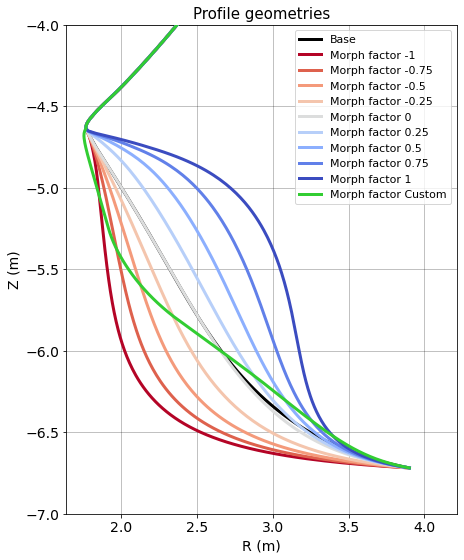

In [78]:
# for i, morph in enumerate(list_morph):
fig, ax = plt.subplots(figsize=(7,9))
ax.plot(data["ou"]["R"], -data["ou"]["Z"], linewidth = 3, linestyle = "solid", zorder = 5, label = f"Base", marker = "o", alpha = 1, markersize = 0, color = "black")

for k, case in enumerate(morph_study_kAr2):
    d = copy.deepcopy(morphdata2[case])
    d["R"] = data["ou"]["R"] *  data["ou"]["Btot"] / d["Btot"]
    
    ax.plot(d["R"], -d["Z"], linewidth = 3, linestyle = "solid", zorder = 5, label = "Morph factor {}".format(d["morph"]), marker = "o", alpha = 1, markersize = 0, color = colors2[k])

    
ylims = ax.axes.get_ylim()

ax.set_title("Profile geometries", fontsize = 15)
ax.legend(fontsize = 11)
ax.set_xlabel("R (m)")
ax.set_ylabel("Z (m)")
ax.grid(color = "black", alpha = 0.3)
ax.set_ylim(-7,-4)

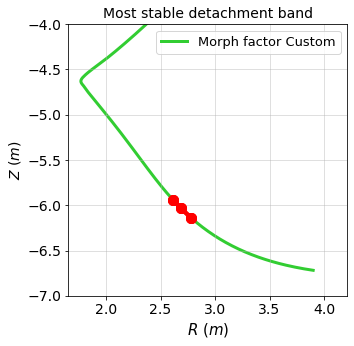

In [883]:
# k = 8
# colors = make_colors(len(list_morph), plt.get_cmap("coolwarm"))[::-1]

fig, ax = plt.subplots(figsize=(5,5))
d = morphdata2["custom"]
o = morph_study_kAr2["custom"]["out"][0]

ax.plot(d["R"], d["Z"]*-1, label = "Morph factor Custom", linewidth = 3, marker = "o", markersize = 0, color = "limegreen", alpha = 1, zorder = 0)

ax.set_xlabel("$R\ (m)$", fontsize = 15)
ax.set_ylabel("$Z\ (m)$")
ax.grid(alpha = 0.5)
ax.set_ylim(-7,-4)
ax.legend(fontsize = 13)
ax.set_title("Most stable detachment band")

min_width = np.nanmin(widths[k])
min_Spol = d["Spol"][np.where(widths[k] == min_width)]

band = make_window_band(d, o, min_Spol)
# band = make_window_band(d, o, 0.5)
color = "red"
for point in range(3):
    ax.plot(band["R"], band["Z"]*-1, markersize = 10, marker = "o", linewidth = 4, color = color)
    # ax.scatter(band["R"][1], -band["Z"][1], s = 100, marker = "o", color = color)
    # ax.scatter(band["R"][0], -band["Z"][0], s = 100, marker = "x", color = color)
    # ax.scatter(band["R"][2], -band["Z"][2], s = 100, marker = "x", color = color)
